# Analysis

## SSRO Average

In [1]:
from notebooks.reset.reset_ssro.ramp_ef_reset_calibration_ssro_all_results import all_results
ramp_ef_all = all_results
from notebooks.reset.reset_ssro.square_e_reset_calibration_ssro_all_results import all_results
square_e_all = all_results

In [2]:
import numpy as np
data_square_e = np.array([ square_e['result']['q17']['reset_fe'] for square_e in square_e_all])
data_ramp_e = np.array([ ramp_ef['result']['q17']['reset_fe'] for ramp_ef in ramp_ef_all])
data_ramp_f = np.array([ ramp_ef['result']['q17']['reset_ff'] for ramp_ef in ramp_ef_all])
f_square_e = 1-np.mean(data_square_e)
f_ramp_e = 1-np.mean(data_ramp_e)
f_ramp_f = 1-np.mean(data_ramp_f)
std_square_e = np.std(data_square_e)
std_ramp_e = np.std(data_ramp_e)
std_ramp_f = np.std(data_ramp_f)

print(f'{f_square_e=}')
print(f'{std_square_e=}')
print(f'{f_ramp_e=}')
print(f'{std_ramp_e=}')
print(f'{f_ramp_f=}')
print(f'{std_ramp_f=}')

f_square_e=0.9923359764366667
std_square_e=0.00533300872455179
f_ramp_e=0.99661848286
std_ramp_e=0.003821835115986479
f_ramp_f=0.93758999816
std_ramp_f=0.006490923764372221


In [5]:
1-f_square_e,1-f_ramp_e,1-f_ramp_f

(0.9923359764366667, 0.99661848286, 0.93758999816)

## Rabi

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv


# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-17`5522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20240530'
path = f'data_dir/{date}'
names = np.sort(listdir(path))
# name = names[-1]
name = '20240530-074114-395-57ec83-rabi_oscillations'
# name = '20240526-031638-622-5edaff-n_rabi_oscillations'
print(name)
dp = f'{path}/{name}/dataset_0.hdf5'
ds = load_dataset(dp)

20240530-074114-395-57ec83-rabi_oscillations


In [5]:
dataset = ds
qubit = 'q23'
x = dataset[f'mw_amplitudes{qubit}'].values # MHz
# x = dataset[f'mw_amplitudes_sweep{qubit}'].values # MHz

qubit = 'q23'
magnitudes0 = np.array([np.linalg.norm(v) for v in dataset[f'y{qubit}']])
qubit = 'q24'
magnitudes1 = np.array([np.linalg.norm(v) for v in dataset[f'y{qubit}']])
# total_magnitude = (magnitudes0+magnitudes1)/2
# sum_list =[]
# for mag in total_magnitude.T:
#     sum_list.append(np.sum(mag))
# min_index = np.argmin(magnitudes0)
# min_index = np.unravel_index(min_index, magnitudes0.shape)
# print(min_index)
# print(x[min_index[1]],y[min_index[0]])
# min_index = [7,18]
# print(min_index)
# print(x[min_index[1]],y[min_index[0]])

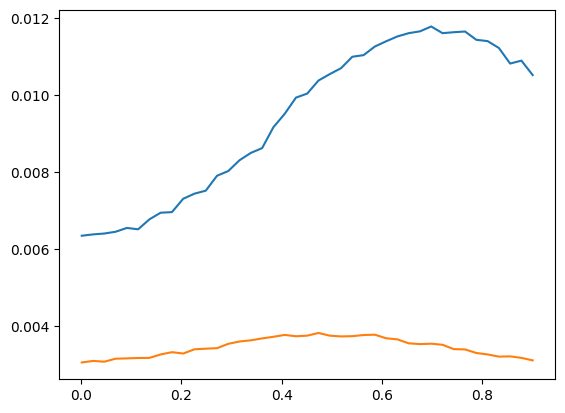

0.0063476756044855654 0.011774925589780789 0.0030598643755730646 0.0038251431067667027


In [6]:
plt.plot(x,magnitudes0)
plt.plot(x,magnitudes1)
plt.show()
q17g,q17e,q22g,q22e=np.min(magnitudes0),np.max(magnitudes0),np.min(magnitudes1),np.max(magnitudes1)
# q17g,q22g = np.mean([magnitudes0[0],q17g]),np.mean([magnitudes1[0],q22g])
print(q17g,q17e,q22g,q22e)

## Reset Adibatic

In [50]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv
from os import listdir
import os
import arrow
import seaborn as sns
from matplotlib import colors


def analyze_reset(data = False, dss = [], date = arrow.now().format('YYYYMMDD'),target = 0,qubits = ['q17','q22'],
                    name = None, savename=['_e_cut','_e','_e'], idx = None, 
                    axis = ['Reset Pulse Amplitudes (mV)','Reset Pulse Durations (ns)'],unit = [100,1e9],
                    label = ['Reset Amplitudes','Reset Duration']):
    # date = '20240316'
    if data == False:
        print('No dataset is provided')
        path = f'data_dir/{date}'
        names = np.sort(listdir(path))
        if name == None:
            name = names[-1]
            # name = '20240314-163302-490-1c0ca2-reset_chevron-pi90_12-f'
        print(name)
        dp = f'data_dir/{date}/{name}/dataset_0.hdf5'
        ds = load_dataset(dp)
        ds = ds.sortby('cz_pulse_amplitudes'+qubits[0])
        ds = ds.sortby('cz_pulse_amplitudes'+qubits[1])
        dss = [ds]
    
    magnitudes0_list = []
    magnitudes1_list = []
    for ds in dss:
        print(f'Analyzing {ds.tuid}')
        ds = ds.sortby('cz_pulse_amplitudes'+qubits[0])
        ds = ds.sortby('cz_pulse_amplitudes'+qubits[1])
        dataset = ds
        qubit = qubits[0]
        x = dataset[f'cz_pulse_amplitudes{qubit}'].values *unit[0] # MHz
        y = dataset[f'cz_pulse_durations{qubit}'].values*unit[1] # ns

        qubit = qubits[0]
        magnitudes0 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
        # q17g,q17e = np.min(magnitudes0),np.max(magnitudes0)
        magnitudes0 = (magnitudes0-q17g)/(q17e-q17g)
        qubit = qubits[1]
        magnitudes1 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
        magnitudes1 = (magnitudes1-q22g)/(q22e-q22g)
        magnitudes0_list.append(magnitudes0)
        magnitudes1_list.append(magnitudes1)
    magnitudes0 = np.mean(magnitudes0_list,axis=0)
    magnitudes1 = np.mean(magnitudes1_list,axis=0)
    # total_magnitude = (magnitudes0+magnitudes1)/2
    # sum_list =[]
    # for mag in total_magnitude.T:
    #     sum_list.append(np.sum(mag))
    if target == 0:
        mag = magnitudes0
    else:
        mag = magnitudes1
    min_index = np.argmin(mag)
    min_index = np.unravel_index(min_index, mag.shape)
    print(min_index)
    print(x[min_index[1]],y[min_index[0]])
    # min_index = [7,18]
    # print(min_index)
    # print(x[min_index[1]],y[min_index[0]])

    # Apply the default theme
    sns.set_theme()
    sns.set_style("ticks")

    plt.figure(figsize=(5,5))
    for i in [0]:
        
        if idx != None:
            plot_index = idx[1]
            min_id = idx[0]
        else:
            plot_index = min_index[1]+i
            min_id = np.argmin(mag.T[plot_index])

        print(f'cz_pulse_amplitudes_idx = {plot_index}')
        print(f'cz_pulse_amplitudes = {x[plot_index]}')
        print(f'min_pop = {np.min(mag.T[plot_index])}')
        print(f'argmin = {min_id}')
        print(f'min_id_pop = {mag.T[plot_index][min_id]}')
        print(f'min_t = {y[min_id]}')
        plt.plot(y, magnitudes0.T[plot_index],'-r',marker="o")
        plt.plot(y, magnitudes1.T[plot_index],'-b',marker="o")
        # plt.plot(y, total_magnitude.T[plot_index],'-k')
        plt.vlines(y[min_id],-1,3,colors='k',linestyles='dashed',label = f'{label[1]} = %1.3f \nReset Fidelity = %1.3f'%(y[min_id],1-mag.T[plot_index][min_id]))
        plt.xlabel(axis[1])
        plt.ylabel('Q0 Reset Fidelity, 1-P0')
        plt.title('Q0 Reset')
        if max(mag.T[plot_index])>1.8:
            ymax = 2
        elif max(mag.T[plot_index])<1:
            ymax = max(mag.T[plot_index])
        else:
            ymax = 1
        if min(mag.T[plot_index])<0:
            ymin = min(mag.T[plot_index])
        else:
            ymin = 0
        plt.ylim(ymin,ymax)
        plt.xlim(min(y),max(y))
        plt.legend(loc='upper right', bbox_to_anchor=(1,0.85))
    path = 'notebooks/reset/'+date+'/'
    os.makedirs(path, exist_ok=True)
    plt.legend(loc='upper right', bbox_to_anchor=(1,1))
    plt.savefig(path+savename[0]+'.png',dpi=300)
    plt.show()

    cm = sns.color_palette("RdBu_r", as_cmap=True)
    sns.set_style("ticks")
    idx = [plot_index,min_id]
    ax = plt.imshow(magnitudes0, aspect='auto',extent =[x.min(), x.max(),y.min(), y.max()],  origin ='lower',cmap = cm, 
    norm=colors.LogNorm()
    )
    plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
    plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = f'{label[0]} = %1.3f \n {label[1]} = %1.3f'%(x[idx[0]],y[idx[1]]))
    plt.xlabel(axis[0])
    plt.ylabel(axis[1])
    plt.title('Q0 Reset Chevron')
    plt.colorbar()
    
    plt.legend(loc='upper right', bbox_to_anchor=(1,1))
    plt.savefig(path+'reset_chevron_'+savename[1]+'_q0'+'.png',dpi=300)
    plt.show()

    # plt.imshow(magnitudes1, aspect='auto',extent =[x.min(), x.max(),y.min(), y.max()],  origin ='lower',cmap = cm)
    # plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
    # plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]))
    # plt.xlabel('Reset Pulse Amplitudes (mV)')
    # plt.ylabel('Reset Pulse Durations (ns)')
    # plt.title('Q1 |1>-state Population')
    # plt.colorbar()
    # plt.savefig(path+'reset_chevron_'+savename[2]+'_q1'+'.png',dpi=300)
    # plt.show()

    # plt.imshow(total_magnitude, aspect='auto',extent =[x.max(), x.min(), y.min(), y.max()],  origin ='lower')
    # plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
    # plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
    # plt.colorbar()
    # plt.show()

In [51]:
# names = ['20240529-110626-420-99280a-reset_chevron_g_ft_f_wide','20240529-111554-542-879041-reset_chevron_g_ft_f_wide']
# names = ['20240530-130232-412-ad2957-reset_chevron_e','20240530-132121-116-580dc0-reset_chevron_f']
# names = ['20240530-150908-553-658636-reset_chevron_e', '20240530-150334-445-edd698-reset_chevron_f']
# names = ['20240531-112124-295-0624d8-reset_chevron','20240531-113130-694-b5f62f-reset_chevron']
# names = ['20240531-141835-522-106bef-reset_chevron_cr_g_f','20240531-142623-606-b7a6b1-reset_chevron_cr_g_e']
names = ['20240604-134950-110-e1d936-reset_chevron_cr_e_gf0_zoom','20240604-222131-024-e93fff-reset_chevron_cr_f_gf0_zoom']
# names = ['20240604-231530-397-f0ada1-reset_chevron_cr_e_gf0_zoom2','20240604-230155-234-90d6f9-reset_chevron_cr_f_gf0_zoom2']
dps = [f'data_dir/{name[:8]}/{name}/dataset_0.hdf5' for name in names]
dss = [load_dataset(dp) for dp in dps]

Analyzing 20240604-134950-110
Analyzing 20240604-222131-024
(24, 9)
1.45 0.12040000000000001
cz_pulse_amplitudes_idx = 9
cz_pulse_amplitudes = 1.45
min_pop = 0.009523427835944735
argmin = 24
min_id_pop = 0.009523427835944735
min_t = 0.12040000000000001


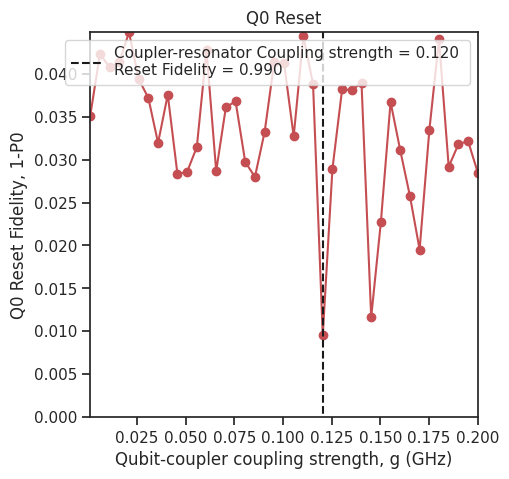

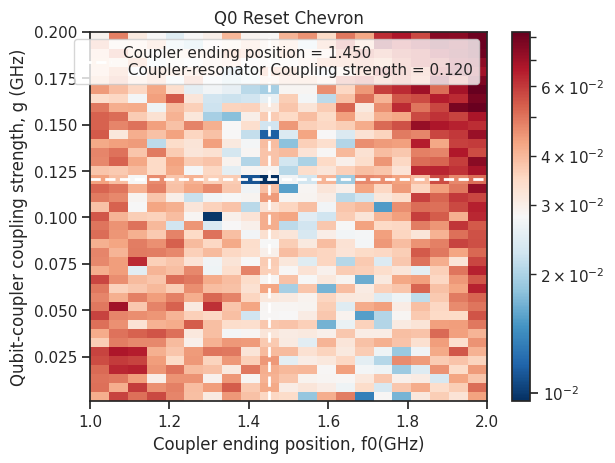

In [52]:

time = 24
amp = 9
analyze_reset(data = True,dss = dss,target = 0,qubits = ['q23','q24'],
                    savename = ['cr_ef_gf0_cut','cr_ef_gf0_q0'], idx = [time,amp],
                    # axis = ['Coupler-resonator detunning, ft (GHz)','Pulse Duration, t (ns)'],
                    # label = ['Coupler-resonator detunning','Pulse Duration'],unit = [1,1e9]
                    axis = ['Coupler ending position, f0(GHz)','Qubit-coupler coupling strength, g (GHz)'],
                    label = ['Coupler ending position','Coupler-resonator Coupling strength'],
                    unit = [1,1])

In [43]:
# names = ['20240529-110626-420-99280a-reset_chevron_g_ft_f_wide','20240529-111554-542-879041-reset_chevron_g_ft_f_wide']
# names = ['20240530-130232-412-ad2957-reset_chevron_e','20240530-132121-116-580dc0-reset_chevron_f']
# names = ['20240530-150908-553-658636-reset_chevron_e', '20240530-150334-445-edd698-reset_chevron_f']
# names = ['20240531-112124-295-0624d8-reset_chevron','20240531-113130-694-b5f62f-reset_chevron']
# names = ['20240531-141835-522-106bef-reset_chevron_cr_g_f','20240531-142623-606-b7a6b1-reset_chevron_cr_g_e']
# names = ['20240604-134950-110-e1d936-reset_chevron_cr_e_gf0_zoom','20240604-222131-024-e93fff-reset_chevron_cr_f_gf0_zoom']
names = ['20240604-231530-397-f0ada1-reset_chevron_cr_e_gf0_zoom2','20240604-230155-234-90d6f9-reset_chevron_cr_f_gf0_zoom2']
dps = [f'data_dir/{name[:8]}/{name}/dataset_0.hdf5' for name in names]
dss = [load_dataset(dp) for dp in dps]

Analyzing 20240604-231530-397
Analyzing 20240604-230155-234
(34, 10)
1.45 0.15999999999999998
cz_pulse_amplitudes_idx = 10
cz_pulse_amplitudes = 1.45
min_pop = 0.011425158971880577
argmin = 34
min_id_pop = 0.011425158971880577
min_t = 0.15999999999999998


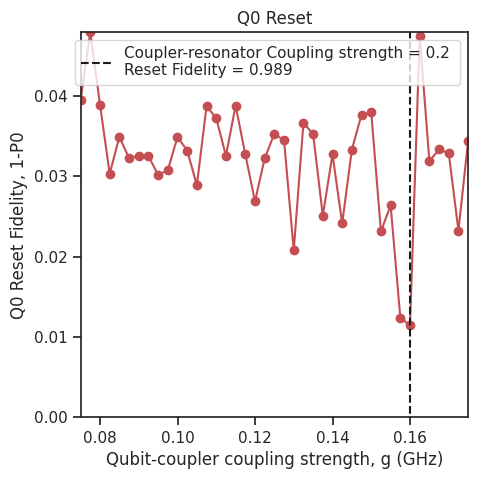

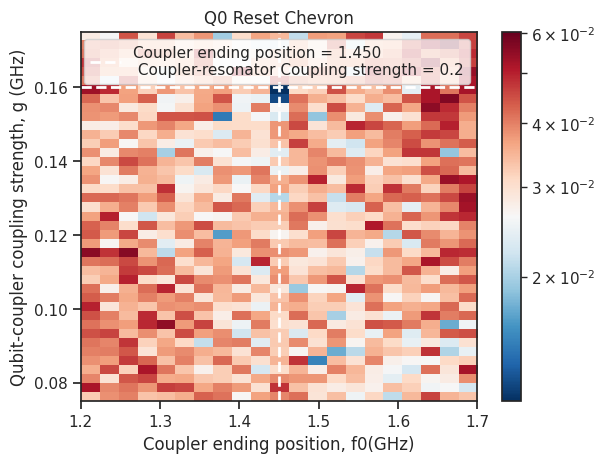

In [46]:

time = 34
amp = 10
analyze_reset(data = True,dss = dss,target = 0,qubits = ['q23','q24'],
                    savename = ['cr_ef_gf0_cut','cr_ef_gf0_q0'], idx = [time,amp],
                    # axis = ['Coupler-resonator detunning, ft (GHz)','Pulse Duration, t (ns)'],
                    # label = ['Coupler-resonator detunning','Pulse Duration'],unit = [1,1e9]
                    axis = ['Coupler ending position, f0(GHz)','Qubit-coupler coupling strength, g (GHz)'],
                    label = ['Coupler ending position','Coupler-resonator Coupling strength'],
                    unit = [1,1])

In [24]:
# names = ['20240529-110626-420-99280a-reset_chevron_g_ft_f_wide','20240529-111554-542-879041-reset_chevron_g_ft_f_wide']
# names = ['20240530-130232-412-ad2957-reset_chevron_e','20240530-132121-116-580dc0-reset_chevron_f']
# names = ['20240530-150908-553-658636-reset_chevron_e', '20240530-150334-445-edd698-reset_chevron_f']
# names = ['20240531-112124-295-0624d8-reset_chevron','20240531-113130-694-b5f62f-reset_chevron']
# names = ['20240531-141835-522-106bef-reset_chevron_cr_g_f','20240531-142623-606-b7a6b1-reset_chevron_cr_g_e']
names = ['20240603-162628-973-b9d322-reset_chevron','20240603-165207-015-6e9ade-reset_chevron']
dps = [f'data_dir/{name[:8]}/{name}/dataset_0.hdf5' for name in names]
dss = [load_dataset(dp) for dp in dps]

Analyzing 20240603-162628-973
Analyzing 20240603-165207-015
(5, 8)
1.0 7.0
cz_pulse_amplitudes_idx = 8
cz_pulse_amplitudes = 1.0
min_pop = 0.008283256291669911
argmin = 5
min_id_pop = 0.008283256291669911
min_t = 7.0


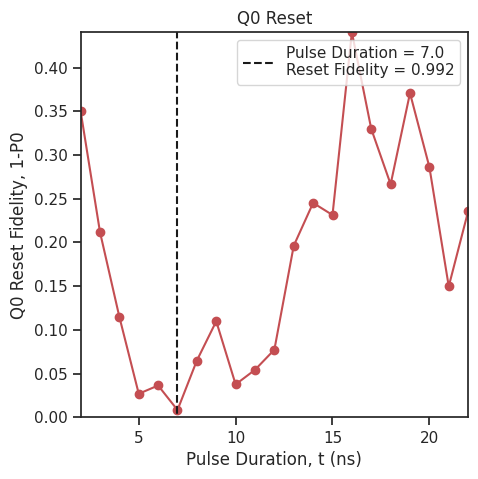

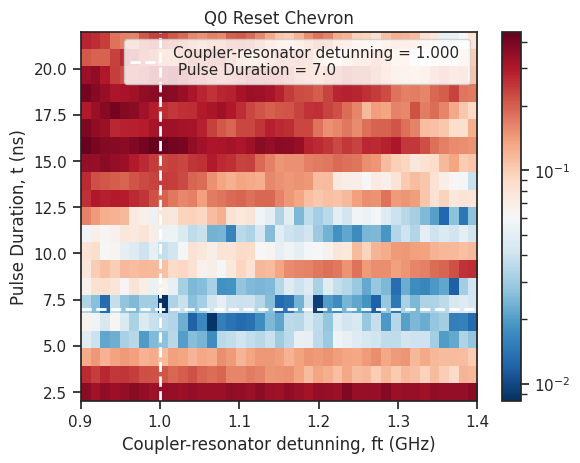

In [31]:
amp = 8
time = 5
analyze_reset(data = True,dss = dss,target = 0,qubits = ['q23','q24'],
                    savename = ['cr_ef_cut','cr_ef_q0'], idx = [time,amp],
                    axis = ['Coupler-resonator detunning, ft (GHz)','Pulse Duration, t (ns)'],
                    label = ['Coupler-resonator detunning','Pulse Duration'],
                    # axis = ['Coupler ending position, f0(MHz)','Qubit-coupler coupling strength, g (MHz)'],
                    # label = ['Coupler ending position','Coupler-resonator Coupling strength'],
                    unit = [1,1e9])

In [13]:
# names = ['20240529-110626-420-99280a-reset_chevron_g_ft_f_wide','20240529-111554-542-879041-reset_chevron_g_ft_f_wide']
# names = ['20240530-130232-412-ad2957-reset_chevron_e','20240530-132121-116-580dc0-reset_chevron_f']
# names = ['20240530-150908-553-658636-reset_chevron_e', '20240530-150334-445-edd698-reset_chevron_f']
# names = ['20240531-112124-295-0624d8-reset_chevron','20240531-113130-694-b5f62f-reset_chevron']
names = ['20240531-141835-522-106bef-reset_chevron_cr_g_f','20240531-142623-606-b7a6b1-reset_chevron_cr_g_e']
# names = ['20240603-162628-973-b9d322-reset_chevron','20240603-165207-015-6e9ade-reset_chevron']
dps = [f'data_dir/{name[:8]}/{name}/dataset_0.hdf5' for name in names]
dss = [load_dataset(dp) for dp in dps]

Analyzing 20240531-141835-522
Analyzing 20240531-142623-606
(7, 12)
890.0 42.65
cz_pulse_amplitudes_idx = 8
cz_pulse_amplitudes = 843.3333333333334
min_pop = 0.03128660346305322
argmin = 5
min_id_pop = 0.5737750130239224
min_t = 30.75


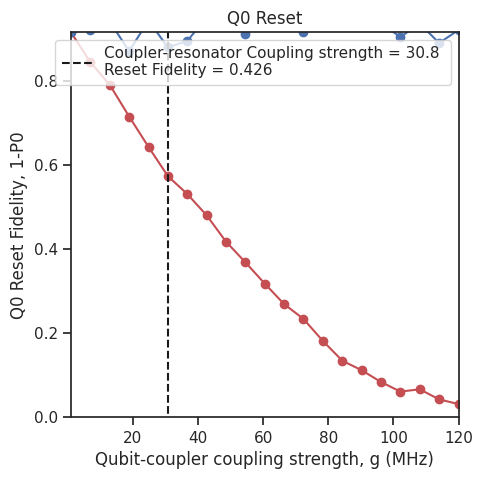

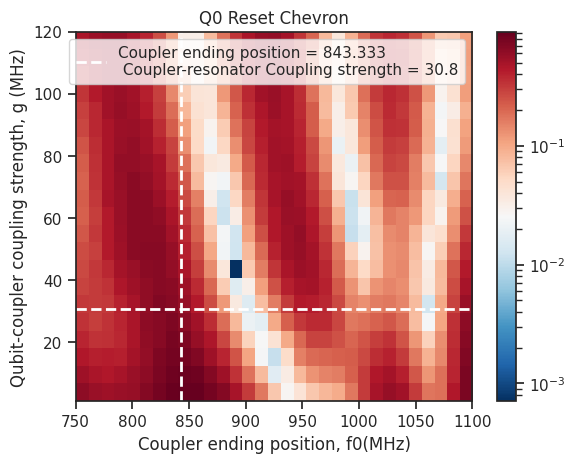

In [14]:
amp = 8
time = 5
analyze_reset(data = True,dss = dss,target = 0,qubits = ['q23','q24'],
                    savename = ['cr_ef_cut','cr_ef_q0'], idx = [time,amp],
                    axis = ['Coupler ending position, f0(MHz)','Qubit-coupler coupling strength, g (MHz)'],
                    label = ['Coupler ending position','Coupler-resonator Coupling strength'],
                    unit = [1000,1000])

In [ ]:
# names = ['20240529-110626-420-99280a-reset_chevron_g_ft_f_wide','20240529-111554-542-879041-reset_chevron_g_ft_f_wide']
# names = ['20240530-130232-412-ad2957-reset_chevron_e','20240530-132121-116-580dc0-reset_chevron_f']
names = ['20240530-150908-553-658636-reset_chevron_e', '20240530-150334-445-edd698-reset_chevron_f']
# names = ['20240531-112124-295-0624d8-reset_chevron','20240531-113130-694-b5f62f-reset_chevron']
dps = [f'data_dir/{name[:8]}/{name}/dataset_0.hdf5' for name in names]
dss = [load_dataset(dp) for dp in dps]

Analyzing 20240530-150908-553
Analyzing 20240530-150334-445
(7, 15)
-150.0 37.50000000000001
cz_pulse_amplitudes_idx = 12
cz_pulse_amplitudes = -180.0
min_pop = 9.592119492519112e-05
argmin = 19
min_id_pop = 0.017003209124757855
min_t = 67.5


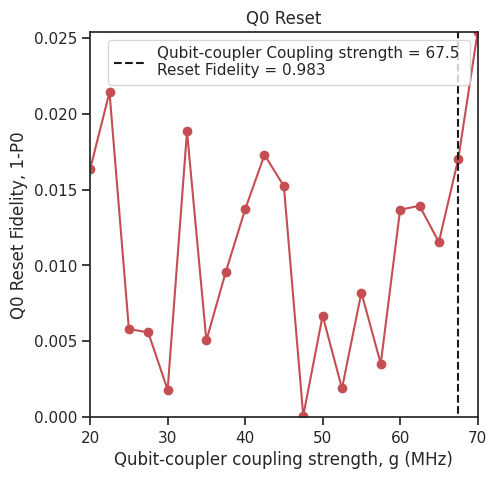

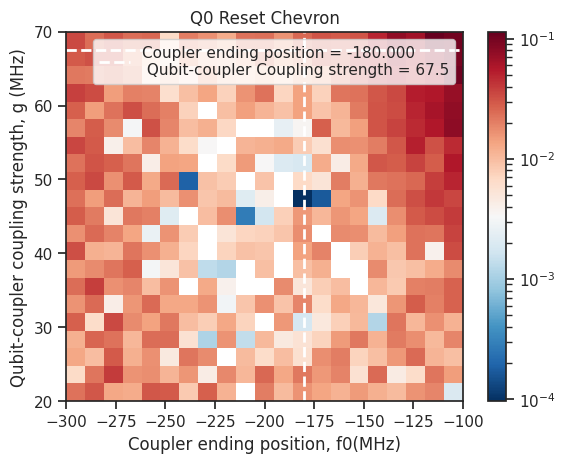

In [472]:
amp = 12
time = 19
analyze_reset(data = True,dss = dss,target = 0,qubits = ['q23','q24'],
                    savename = ['qc_e_cut_g_ft_f_zoom_1','qc_e_f0_g_ft_f_zoom','qc_e_f0_g_ft_f_zoom_1'], idx = [time,amp],
                    axis = ['Coupler ending position, f0(MHz)','Qubit-coupler coupling strength, g (MHz)'],
                    label = ['Coupler ending position','Qubit-coupler Coupling strength'],
                    unit = [1000,1000])

In [426]:
names = ['20240528-202420-243-f355cc-reset_chevron_e','20240528-230933-181-5dfe26-reset_chevron_e1','20240528-234231-850-b6bf36-reset_chevron_e2','20240529-100428-346-ea0b96-reset_chevron_e3']
dps = [f'data_dir/{name[:8]}/{name}/dataset_0.hdf5' for name in names]
dss = [load_dataset(dp) for dp in dps]
ds = xr.merge(dss, compat='no_conflicts')

(22, 5)
85.0 27.000000000000004
cz_pulse_amplitudes_idx = 9
cz_pulse_amplitudes = 93.0
min_pop = 0.0017519266775532687
argmin = 4
min_id_pop = 0.007576837970367246
min_t = 9.000000000000002


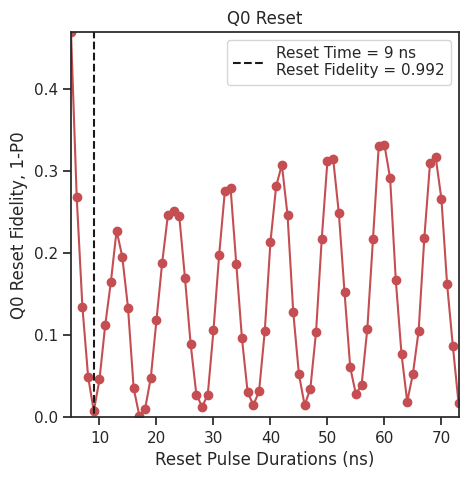

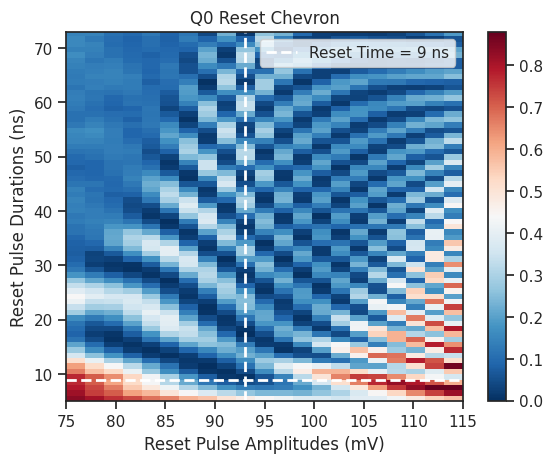

In [335]:
amp = 9
time = 4
analyze_reset(data = True,ds = ds,target = 0,qubits = ['q23','q24'],
                    savename = ['qc_e_cut_f0_t','qc_e_f0_t','qc_e_f0_t'], idx = [time,amp])

In [309]:
names = ['20240528-210241-756-efc01f-reset_chevron_f','20240528-221144-550-59a7b7-reset_chevron_f1','20240529-001737-295-8ca196-reset_chevron_f2','20240529-004306-099-d39f4c-reset_chevron_f3']
dps = [f'data_dir/{name[:8]}/{name}/dataset_0.hdf5' for name in names]
dss = [load_dataset(dp) for dp in dps]
dss
ds = xr.merge(dss, compat='no_conflicts')


(4, 9)
93.0 9.000000000000002
cz_pulse_amplitudes_idx = 9
cz_pulse_amplitudes = 93.0
min_pop = 0.009575623488251236
argmin = 4
min_id_pop = 0.009575623488251236
min_t = 9.000000000000002


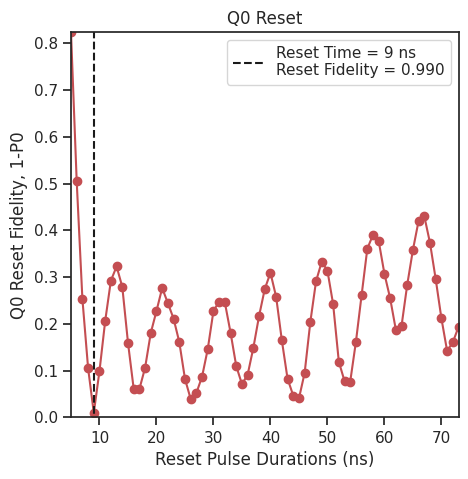

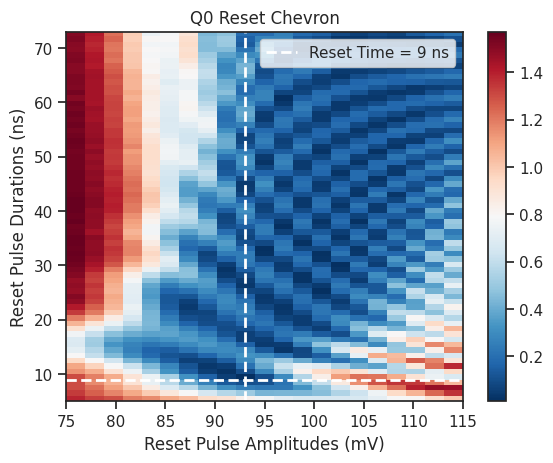

In [314]:
amp = 9
time = 4
analyze_reset(data = True,ds = ds,target = 0,qubits = ['q23','q24'],
                    savename = ['qc_f_cut_f0_t','qc_f_f0_t','qc_f_f0_t'], idx = [time,amp])

## Reset

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv
from os import listdir
import os
import arrow
import seaborn as sns


def analyze_reset(data = False, ds = None, date = arrow.now().format('YYYYMMDD'),target = 0,qubits = ['q17','q22'],
                    name = None, savename=['_e_cut','_e','_e'], idx = None):
    # date = '20240316'
    if data == False:
        print('No dataset is provided')
        path = f'data_dir/{date}'
        names = np.sort(listdir(path))
        if name == None:
            name = names[-1]
            # name = '20240314-163302-490-1c0ca2-reset_chevron-pi90_12-f'
        print(name)
        dp = f'data_dir/{date}/{name}/dataset_0.hdf5'
        ds = load_dataset(dp)
        ds = ds.sortby('cz_pulse_amplitudes'+qubits[0])
        ds = ds.sortby('cz_pulse_amplitudes'+qubits[1])
    dataset = ds
    qubit = qubits[0]
    x = dataset[f'cz_pulse_amplitudes{qubit}'].values *100 # MHz
    y = dataset[f'cz_pulse_durations{qubit}'].values*1e9 # ns

    qubit = qubits[0]
    magnitudes0 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
    # q17g,q17e = np.min(magnitudes0),np.max(magnitudes0)
    magnitudes0 = (magnitudes0-q17g)/(q17e-q17g)
    qubit = qubits[1]
    magnitudes1 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
    magnitudes1 = (magnitudes1-q22g)/(q22e-q22g)
    total_magnitude = (magnitudes0+magnitudes1)/2
    # sum_list =[]
    # for mag in total_magnitude.T:
    #     sum_list.append(np.sum(mag))
    if target == 0:
        mag = magnitudes0
    else:
        mag = magnitudes1
    min_index = np.argmin(mag)
    min_index = np.unravel_index(min_index, mag.shape)
    print(min_index)
    print(x[min_index[1]],y[min_index[0]])
    # min_index = [7,18]
    # print(min_index)
    # print(x[min_index[1]],y[min_index[0]])

    # Apply the default theme
    sns.set_theme()
    sns.set_style("ticks")

    plt.figure(figsize=(5,5))
    for i in [0]:
        
        if idx != None:
            plot_index = idx[1]
            min_id = idx[0]
        else:
            plot_index = min_index[1]+i
            min_id = np.argmin(mag.T[plot_index])

        print(f'cz_pulse_amplitudes_idx = {plot_index}')
        print(f'cz_pulse_amplitudes = {x[plot_index]}')
        print(f'min_pop = {np.min(mag.T[plot_index])}')
        print(f'argmin = {min_id}')
        print(f'min_id_pop = {mag.T[plot_index][min_id]}')
        print(f'min_t = {y[min_id]}')
        plt.plot(y, magnitudes0.T[plot_index],'-r',marker="o")
        plt.plot(y, magnitudes1.T[plot_index],'-b',marker="o")
        # plt.plot(y, total_magnitude.T[plot_index],'-k')
        plt.vlines(y[min_id],-1,3,colors='k',linestyles='dashed',label = 'Reset Time = %1.0f ns \nReset Fidelity = %1.3f'%(y[min_id],1-mag.T[plot_index][min_id]))
        plt.xlabel('Reset Pulse Durations (ns)')
        plt.ylabel('Q0 Reset Fidelity, 1-P0')
        plt.title('Q0 Reset')
        if max(mag.T[plot_index])>1.8:
            ymax = 2
        else:
            ymax = max(mag.T[plot_index])
        if min(mag.T[plot_index])<0:
            ymin = min(mag.T[plot_index])
        else:
            ymin = 0
        plt.ylim(ymin,ymax)
        plt.xlim(min(y),max(y))
        plt.legend(loc='upper right', bbox_to_anchor=(1,0.85))
    path = 'notebooks/reset/'+date+'/'
    os.makedirs(path, exist_ok=True)
    plt.legend(loc='upper right', bbox_to_anchor=(1,1))
    plt.savefig(path+savename[0]+'.png',dpi=300)
    plt.show()

    cm = sns.color_palette("RdBu_r", as_cmap=True)
    sns.set_style("ticks")
    idx = [plot_index,min_id]
    ax = plt.imshow(magnitudes0, aspect='auto',extent =[x.min(), x.max(),y.min(), y.max()],  origin ='lower',cmap = cm)
    plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
    plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]))
    plt.xlabel('Reset Pulse Amplitudes (mV)')
    plt.ylabel('Reset Pulse Durations (ns)')
    plt.title('Q0 Reset Chevron')
    plt.colorbar()
    plt.legend(loc='upper right', bbox_to_anchor=(1,1))
    plt.savefig(path+'reset_chevron_'+savename[1]+'_q0'+'.png',dpi=300)
    plt.show()

    # plt.imshow(magnitudes1, aspect='auto',extent =[x.min(), x.max(),y.min(), y.max()],  origin ='lower',cmap = cm)
    # plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
    # plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]))
    # plt.xlabel('Reset Pulse Amplitudes (mV)')
    # plt.ylabel('Reset Pulse Durations (ns)')
    # plt.title('Q1 |1>-state Population')
    # plt.colorbar()
    # plt.savefig(path+'reset_chevron_'+savename[2]+'_q1'+'.png',dpi=300)
    # plt.show()

    # plt.imshow(total_magnitude, aspect='auto',extent =[x.max(), x.min(), y.min(), y.max()],  origin ='lower')
    # plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
    # plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
    # plt.colorbar()
    # plt.show()

20240528-142932-989-860e3e-reset_chevron_e
(13, 6)
-42.0 18.000000000000004
cz_pulse_amplitudes_idx = 5
cz_pulse_amplitudes = -44.99999999999999
min_pop = -0.010357051570038366
argmin = 4
min_id_pop = 0.49041155609813647
min_t = 9.000000000000002


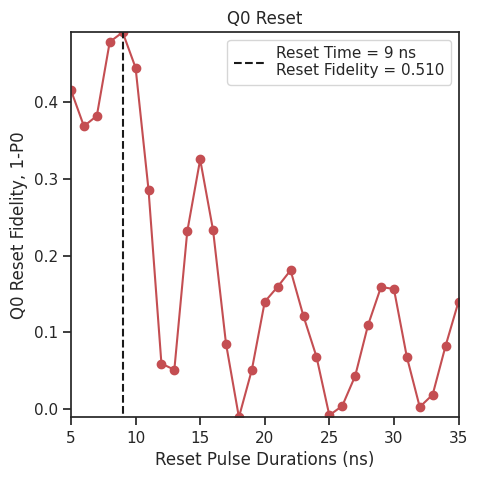

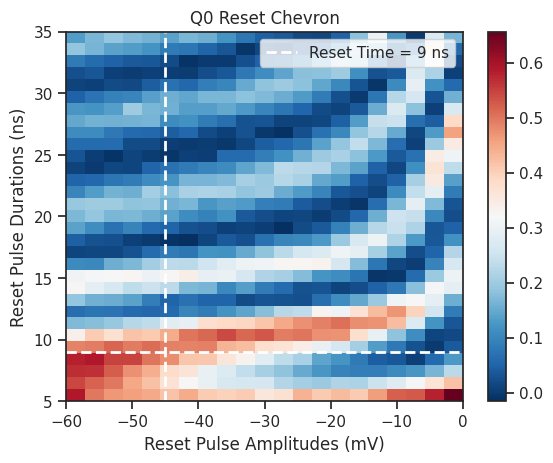

20240528-130358-838-619746-reset_chevron_f
(20, 7)
-39.0 25.0
cz_pulse_amplitudes_idx = 5
cz_pulse_amplitudes = -44.99999999999999
min_pop = -0.0002836158576728238
argmin = 4
min_id_pop = 0.794296770001535
min_t = 9.000000000000002


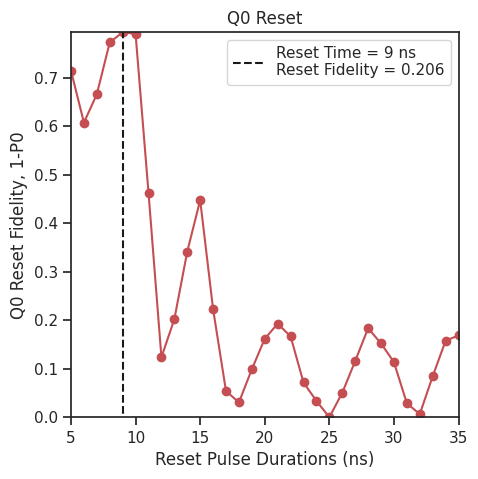

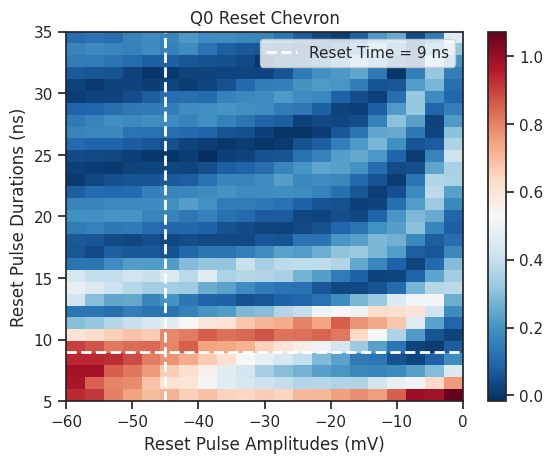

In [221]:
amp = 12
time = 4
analyze_reset(date = '20240528',target = 0,qubits = ['q23','q24'],
                    name = '20240528-142932-989-860e3e-reset_chevron_e', 
                    savename = ['qc_e_cut_ft','qc_e_ft','qc_e_ft'], idx = [time,amp])
analyze_reset(date = '20240528',target = 0,qubits = ['q23','q24'],
                    name = '20240528-130358-838-619746-reset_chevron_f',
                    savename = ['qc_f_cut_ft','qc_f_ft','qc_f_ft'], idx = [time,amp])

20240528-114115-071-1fff14-reset_chevron_e
(15, 12)
99.0 20.0
cz_pulse_amplitudes_idx = 9
cz_pulse_amplitudes = 93.0
min_pop = -0.006153527216652101
argmin = 4
min_id_pop = -0.006153527216652101
min_t = 9.000000000000002


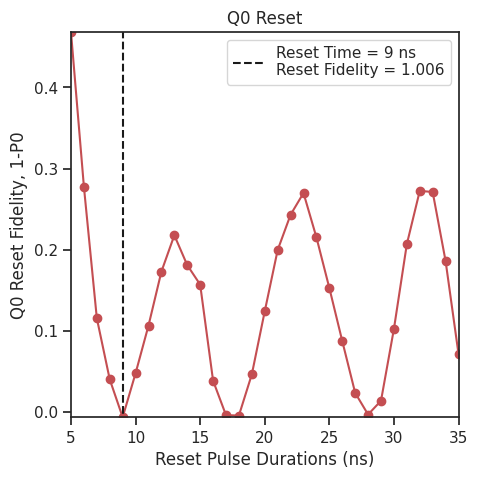

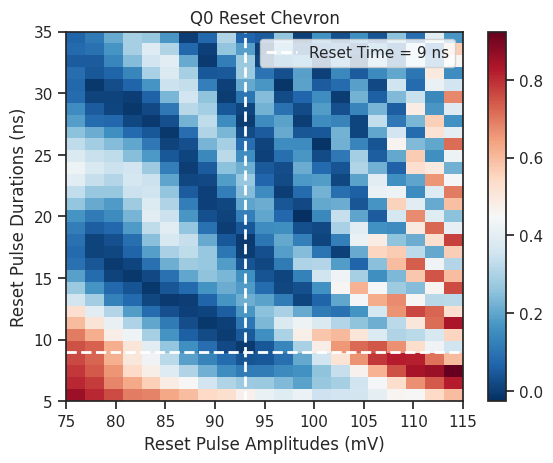

20240528-115004-319-a49fdd-reset_chevron_f
(24, 14)
103.0 29.0
cz_pulse_amplitudes_idx = 9
cz_pulse_amplitudes = 93.0
min_pop = -0.0006737078826409849
argmin = 4
min_id_pop = -0.0006737078826409849
min_t = 9.000000000000002


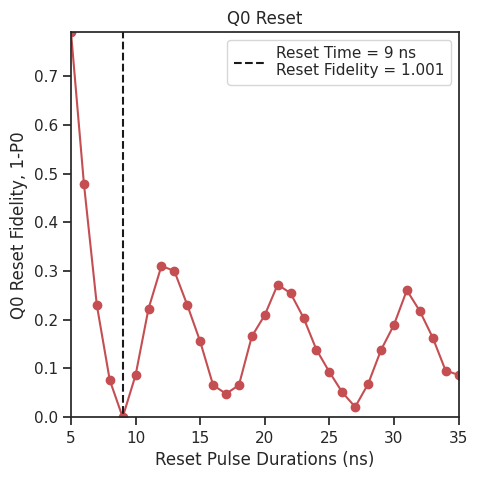

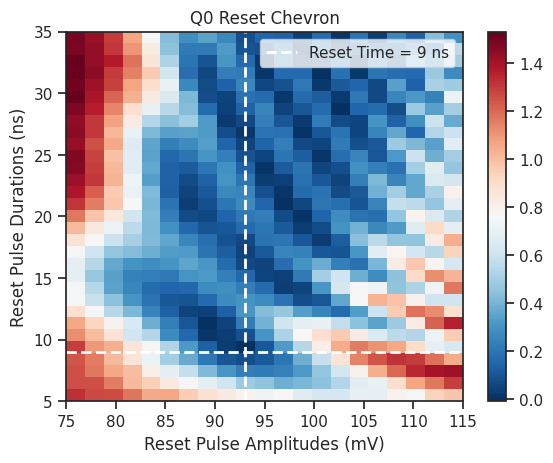

In [218]:
amp = 9
time = 4
analyze_reset(date = '20240528',target = 0,qubits = ['q23','q24'],
                    name = '20240528-114115-071-1fff14-reset_chevron_e', 
                    savename = ['qc_e_cut','qc_e','qc_e'], idx = [time,amp])
analyze_reset(date = '20240528',target = 0,qubits = ['q23','q24'],
                    name = '20240528-115004-319-a49fdd-reset_chevron_f', 
                    savename = ['qc_f_cut','qc_f','qc_f'], idx = [time,amp])

20240528-115004-319-a49fdd-reset_chevron_f
(24, 14)
103.0 29.0
cz_pulse_amplitudes_idx = 9
cz_pulse_amplitudes = 93.0
min_pop = -0.0006737078826409849
argmin = 4
min_id_pop = -0.0006737078826409849
min_t = 9.000000000000002


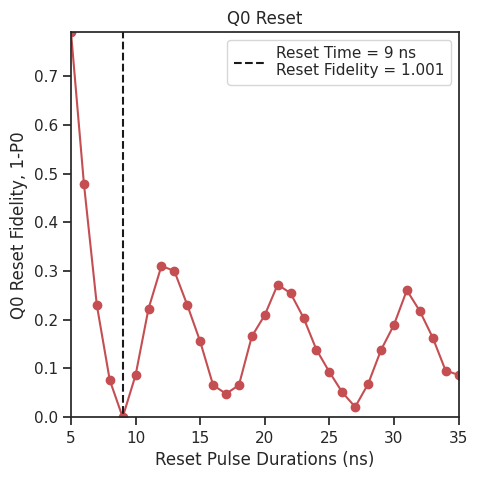

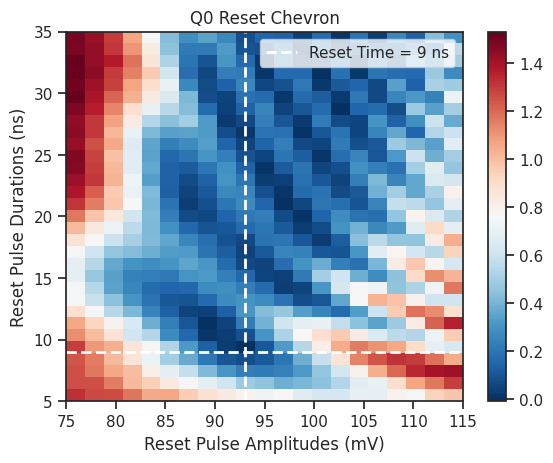

In [52]:
analyze_reset(date = '20240527',target = 0,qubits = ['q23','q24'],
                    name = None, 
                    savename = ['qc_cut','qc_e','qc_e'], idx = [39,8])

20240527-231512-997-b6ca48-reset_chevron
(15, 3)
78.0 17.000000000000004
cz_pulse_amplitudes_idx = 8
cz_pulse_amplitudes = 108.0
min_pop = 0.0065953587930925005
argmin = 39


IndexError: index 39 is out of bounds for axis 0 with size 31

<Figure size 500x500 with 0 Axes>

20240527-175537-878-32ba20-reset_chevron
(44, 3)
-9.4 34.00000000000001
cz_pulse_amplitudes_idx = 8
cz_pulse_amplitudes = -8.4
min_pop = 0.006719813628036935
argmin = 57
min_id_pop = 0.007156644802030664
min_t = 43.75000000000001


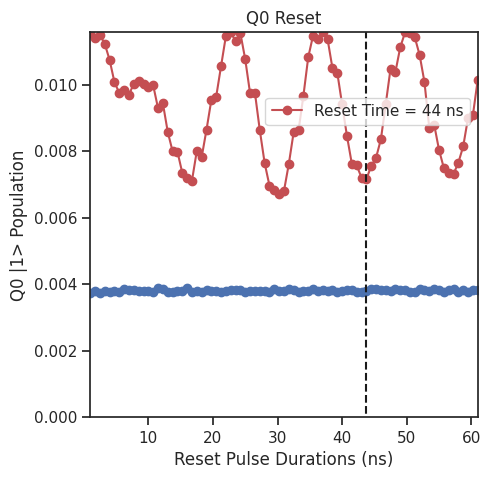

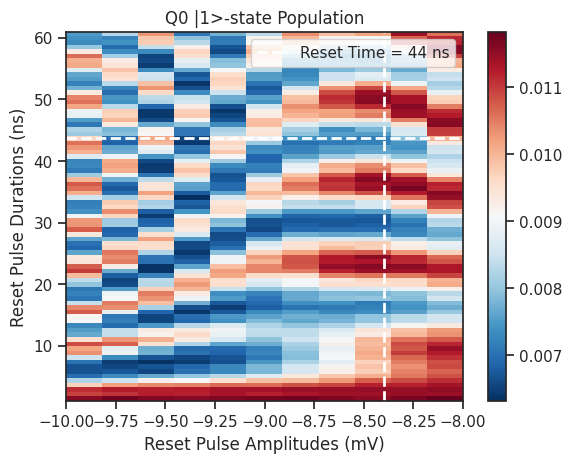

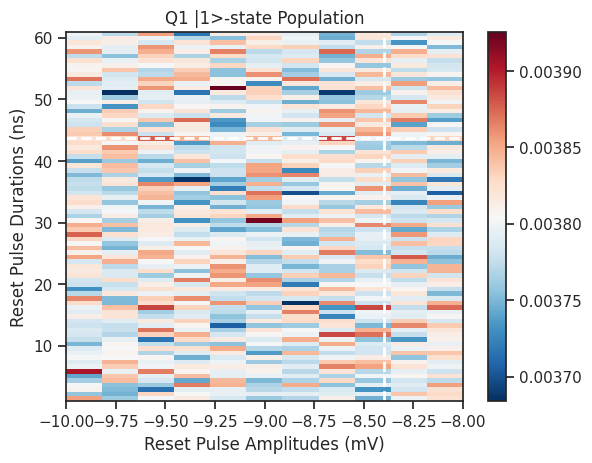

In [47]:
analyze_reset(date = '20240527',target = 0,qubits = ['q23','q24'],
                    name = None, 
                    savename = ['qc_cut_1','qc_e','qc_e'], idx = [57,8])

In [45]:
1/((44-30)*1e-9)/1e6

71.42857142857142

In [33]:
analyze_reset(date = '20240321',target = 0,qubits = ['q17','q22'],
                    name = '20240321-164300-188-7b74a0-reset_chevron_qc_s_e', 
                    savename=['qc_d_e_cut','qc_d_e','qc_d_e'], idx = [15,7])

FileNotFoundError: [Errno 2] No such file or directory: 'data_dir/20240321'

20240319-155727-168-e5763a-reset_chevron_800_cr_ef
(18, 10)
-8.75 903.9999999999999
cz_pulse_amplitudes_idx = 10
cz_pulse_amplitudes = -8.75
min_pop = 0.024235404417097716
argmin = 18
min_id_pop = 0.024235404417097716
min_t = 903.9999999999999


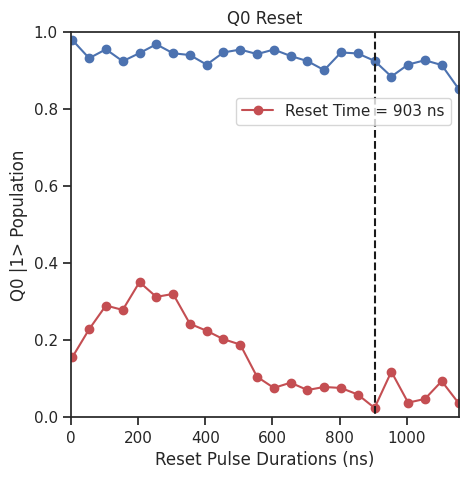

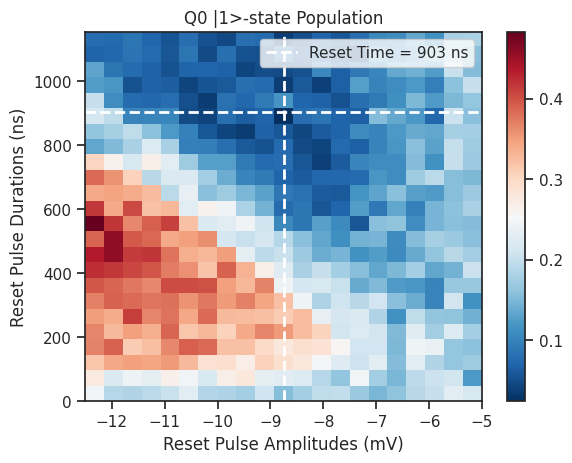

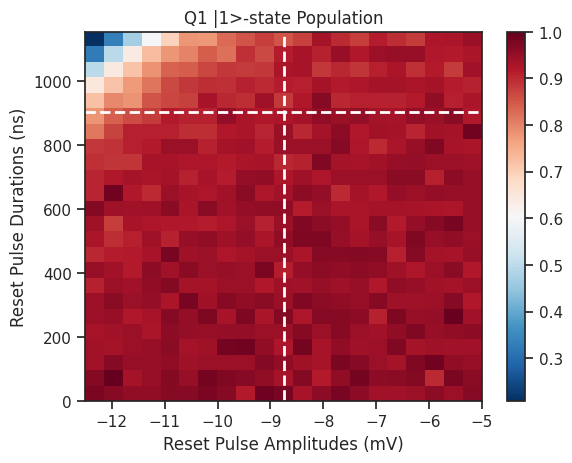

In [26]:
analyze_reset(date = '20240319',target = 0,qubits = ['q17','q22'],
                    name = '20240319-155727-168-e5763a-reset_chevron_800_cr_ef', 
                    savename=['cr_ef_cut','cr_ef','cr_ef'], idx = None)

20240319-150413-297-bc2193-reset_chevron_800_qc_ef
(31, 9)
9.5 624.0
cz_pulse_amplitudes_idx = 8
cz_pulse_amplitudes = 9.0
min_pop = 0.03065783669336351
argmin = 35
min_id_pop = 0.044705129751351644
min_t = 704.0


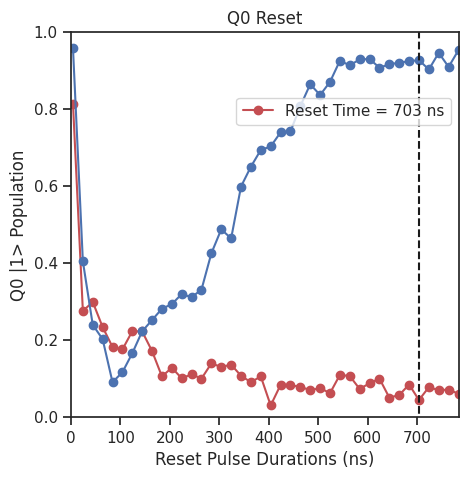

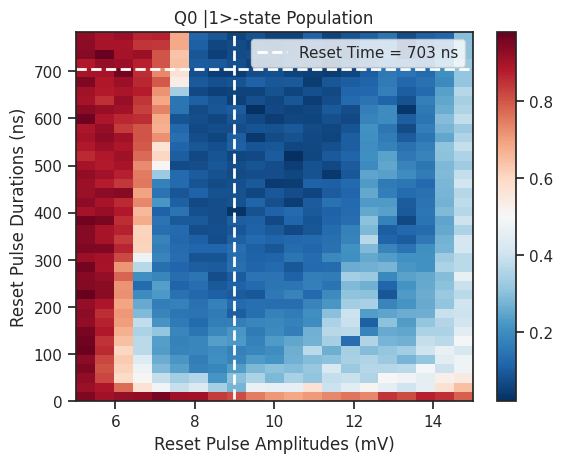

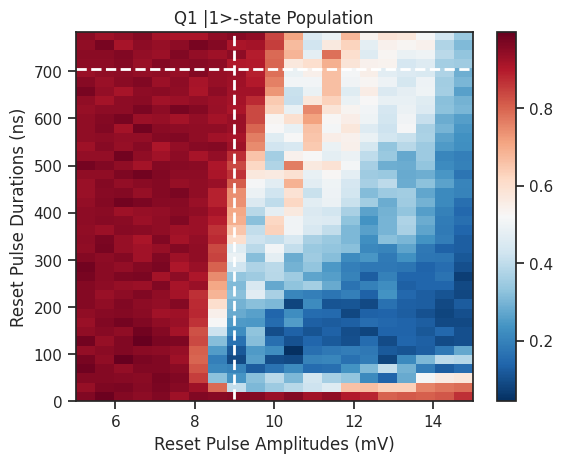

In [27]:
analyze_reset(date = '20240319',target = 0,qubits = ['q17','q22'],
                    name = '20240319-150413-297-bc2193-reset_chevron_800_qc_ef', 
                    savename=['qc_ef_cut','qc_ef','qc_ef'], idx = [35,8])

20240319-103847-217-f99c1f-reset_chevron_d1.5
(38, 14)
15.000000000000002 764.0
cz_pulse_amplitudes_idx = 13
cz_pulse_amplitudes = 14.000000000000002
min_pop = 0.03880421165404276
argmin = 38
min_id_pop = 0.05817098935320605
min_t = 764.0


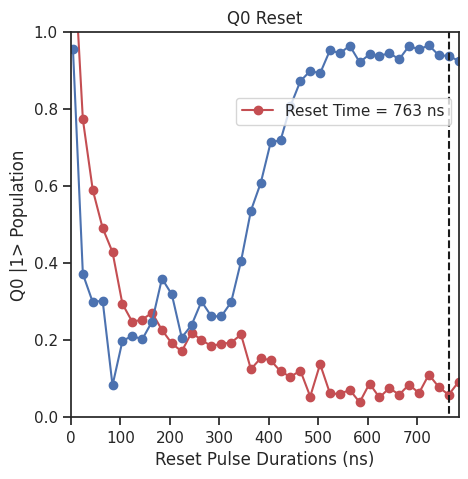

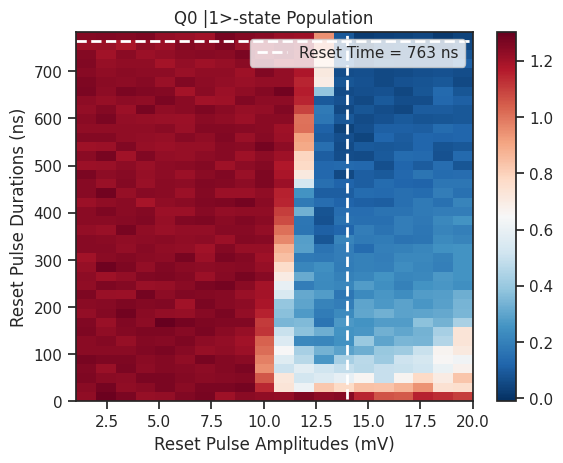

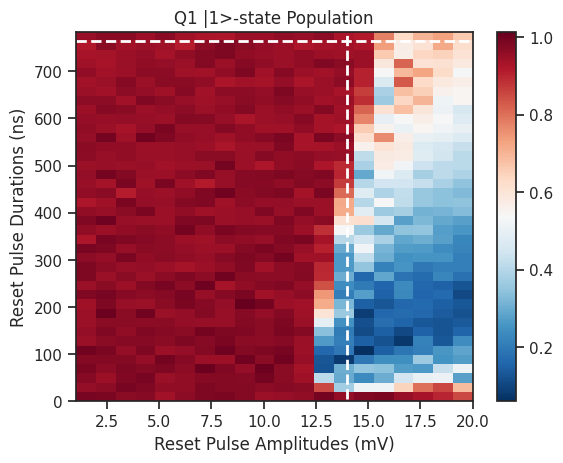

In [28]:
analyze_reset(date = '20240319',target = 0,qubits = ['q17','q22'],
                    name = '20240319-103847-217-f99c1f-reset_chevron_d1.5', 
                    savename=['ef_cut','ef','ef'], idx = [38,13])

20240319-122212-272-897fc2-reset_chevron
(11, 19)
-1.0 554.0
cz_pulse_amplitudes_idx = 19
cz_pulse_amplitudes = -1.0
min_pop = -0.025872705527056252
argmin = 1
min_id_pop = 0.037845290020396924
min_t = 54.0


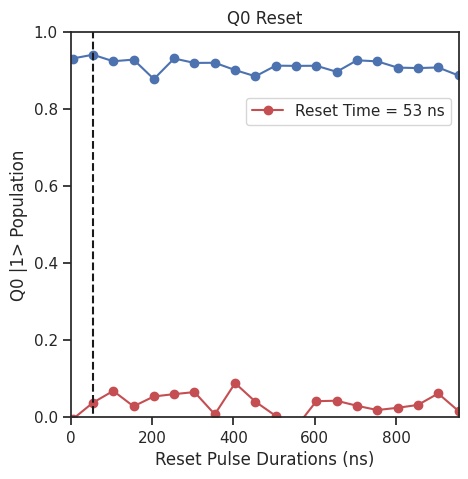

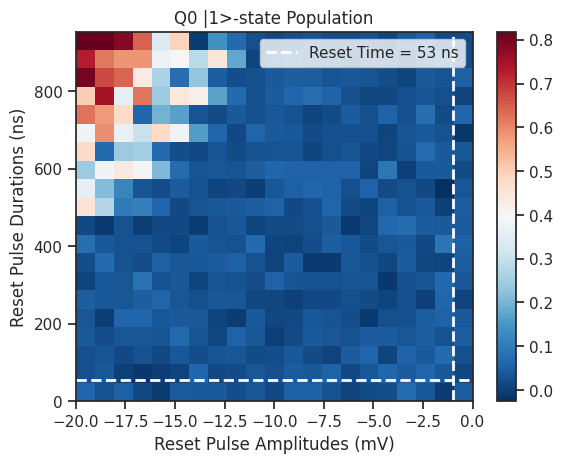

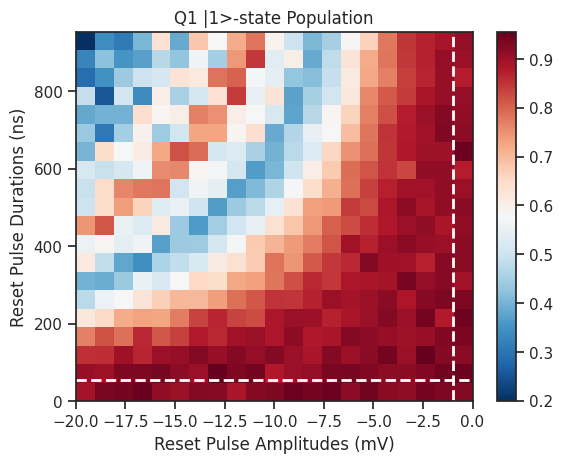

In [29]:
analyze_reset(date = '20240319',target = 0,qubits = ['q17','q22'],
                    name = '20240319-122212-272-897fc2-reset_chevron', 
                    savename=['cr_ef_cut','cr_ef','cr_ef'], idx = [1,19])

## Reset QC - e

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv


# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-17`5522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20240316'
path = f'data_directory/{date}'
names = np.sort(listdir(path))
name = names[-1]
# name = '20240314-163302-490-1c0ca2-reset_chevron-pi90_12-f'
print(name)
dp = f'data_directory/{date}/{name}/dataset.hdf5'
ds = load_dataset(dp)
ds = ds.sortby('cz_pulse_amplitudesq17')
ds = ds.sortby('cz_pulse_amplitudesq22')

FileNotFoundError: [Errno 2] No such file or directory: 'data_directory/20240316'

In [ ]:
dataset = ds
qubit = 'q17'
x = dataset[f'cz_pulse_amplitudes{qubit}'].values *100 # MHz
y = dataset[f'cz_pulse_durations{qubit}'].values*1e9 # ns

qubit = 'q17'
magnitudes0 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
# q17g,q17e = np.min(magnitudes0),np.max(magnitudes0)
magnitudes0 = (magnitudes0-q17g)/(q17e-q17g)
qubit = 'q22'
magnitudes1 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes1 = (magnitudes1-q22g)/(q22e-q22g)
total_magnitude = (magnitudes0+magnitudes1)/2
# sum_list =[]
# for mag in total_magnitude.T:
#     sum_list.append(np.sum(mag))
min_index = np.argmin(magnitudes0)
min_index = np.unravel_index(min_index, magnitudes0.shape)
print(min_index)
print(x[min_index[1]],y[min_index[0]])
# min_index = [7,18]
# print(min_index)
# print(x[min_index[1]],y[min_index[0]])

(4, 13)
12.210526315789474 1201.0


cz_pulse_amplitudes_idx = 13
cz_pulse_amplitudes = 12.210526315789474
min = 0.09811051991353346
argmin = 4
min_pop = 0.09811051991353346
min_t = 1201.0


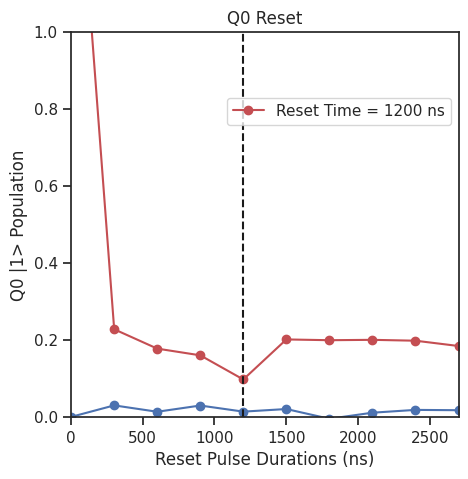

In [ ]:
%matplotlib inline

import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.set_style("ticks")

plt.figure(figsize=(5,5))
for i in [0]:
    plot_index = min_index[1]+i
    print(f'cz_pulse_amplitudes_idx = {plot_index}')
    # plot_index = 12
    print(f'cz_pulse_amplitudes = {x[plot_index]}')
    print(f'min = {np.min(magnitudes0.T[plot_index])}')
    min_id = np.argmin(magnitudes0.T[plot_index])
    # min_id = 25
    print(f'argmin = {min_id}')
    print(f'min_pop = {magnitudes0.T[plot_index][min_id]}')
    print(f'min_t = {y[min_id]}')
    plt.plot(y, magnitudes0.T[plot_index],'-r',marker="o",label = 'Reset Time = %1.0f ns'%(y[min_id]-1))
    plt.plot(y, magnitudes1.T[plot_index],'-b',marker="o")
    # plt.plot(y, total_magnitude.T[plot_index],'-k')
    plt.vlines(y[min_id],0,1,colors='k',linestyles='dashed')
    plt.xlabel('Reset Pulse Durations (ns)')
    plt.ylabel('Q0 |1> Population')
    plt.title('Q0 Reset')
    plt.ylim(0,1)
    plt.xlim(0,max(y))
    plt.legend(loc='upper right', bbox_to_anchor=(1,0.85))
plt.savefig('images/reset/202403/reset_chevron_q0_e_cut.png',dpi=300)
plt.show()

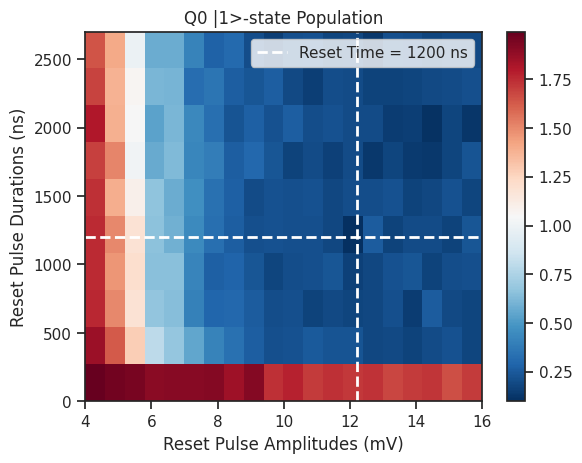

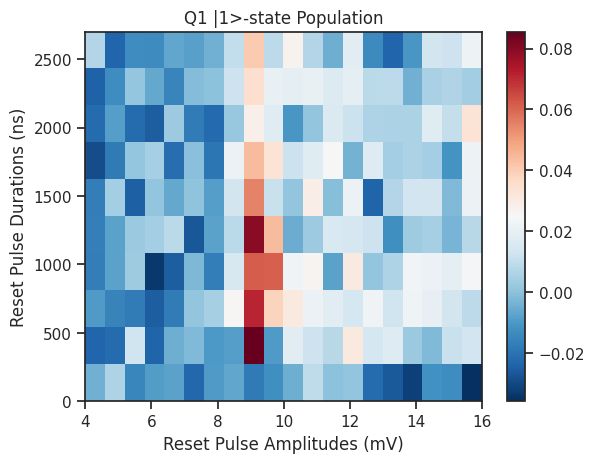

In [ ]:
cm = sns.color_palette("RdBu_r", as_cmap=True)
sns.set_style("ticks")
idx = [plot_index,min_id]
ax = plt.imshow(magnitudes0, aspect='auto',extent =[x.min(), x.max(),0, y.max()],  origin ='lower',cmap = cm)
plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]-1))
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q0 |1>-state Population')
plt.colorbar()
plt.legend(loc='upper right', bbox_to_anchor=(1,1))
plt.savefig('images/reset/202403/reset_chevron_q0_e.png',dpi=300)
plt.show()

plt.imshow(magnitudes1, aspect='auto',extent =[x.min(), x.max(),0, y.max()],  origin ='lower',cmap = cm)
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q1 |1>-state Population')
plt.colorbar()
plt.savefig('images/reset/202403/reset_chevron_q0_e.png',dpi=300)
plt.show()
# plt.imshow(total_magnitude, aspect='auto',extent =[x.max(), x.min(), y.min(), y.max()],  origin ='lower')
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
# plt.colorbar()
# plt.show()

## Reset QC - f

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv


# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-17`5522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20240315'
path = f'data_directory/{date}'
names = np.sort(listdir(path))
# name = names[-1]
name = '20240315-095614-162-3889e0-reset_chevron-pi90_12-f-4096'
print(name)
dp = f'data_directory/{date}/{name}/dataset.hdf5'
ds = load_dataset(dp)
ds = ds.sortby('cz_pulse_amplitudesq17')
ds = ds.sortby('cz_pulse_amplitudesq22')

20240315-095614-162-3889e0-reset_chevron-pi90_12-f-4096


In [ ]:
dataset = ds
qubit = 'q17'
x = dataset[f'cz_pulse_amplitudes{qubit}'].values *100 # MHz
y = dataset[f'cz_pulse_durations{qubit}'].values*1e9 # ns

qubit = 'q17'
magnitudes0 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes0 = (magnitudes0-q17g)/(q17e-q17g)
qubit = 'q22'
magnitudes1 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes1 = (magnitudes1-q22g)/(q22e-q22g)
total_magnitude = (magnitudes0+magnitudes1)/2
# sum_list =[]
# for mag in total_magnitude.T:
#     sum_list.append(np.sum(mag))
min_index = np.argmin(magnitudes0)
min_index = np.unravel_index(min_index, magnitudes0.shape)
print(min_index)
print(x[min_index[1]],y[min_index[0]])
# min_index = [7,18]
# print(min_index)
# print(x[min_index[1]],y[min_index[0]])

(20, 9)
4.842105263157895 800.9999999999999


In [ ]:
0.15/(0.19-0.15)*0.6+3.9

6.1499999999999995

cz_pulse_amplitudes_idx = 9
cz_pulse_amplitudes = 4.842105263157895
min = -0.007074070410686483
argmin = 20
min_t = 800.9999999999999


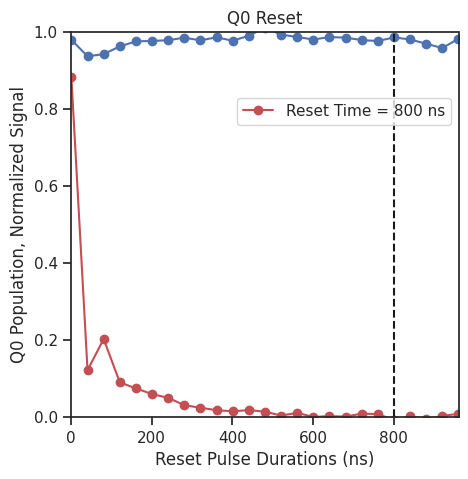

In [ ]:
%matplotlib inline

import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.set_style("ticks")

plt.figure(figsize=(5,5))
for i in [0]:
    plot_index = min_index[1]+i
    # plot_index = 13
    print(f'cz_pulse_amplitudes_idx = {plot_index}')
    print(f'cz_pulse_amplitudes = {x[plot_index]}')
    print(f'min = {np.min(magnitudes0.T[plot_index])}')
    min_id = np.argmin(magnitudes0.T[plot_index])
    # min_id = 26
    print(f'argmin = {min_id}')
    print(f'min_t = {y[min_id]}')
    plt.plot(y, magnitudes0.T[plot_index],'-r',marker="o",label = 'Reset Time = %1.0f ns'%(y[min_id]-1))
    plt.plot(y, magnitudes1.T[plot_index],'-b',marker="o")
    # plt.plot(y, total_magnitude.T[plot_index],'-k')
    plt.vlines(y[min_id],0,1,colors='k',linestyles='dashed')
    plt.xlabel('Reset Pulse Durations (ns)')
    plt.ylabel('Q0 Population, Normalized Signal')
    plt.title('Q0 Reset')
    plt.ylim(0,1)
    plt.xlim(0,max(y))
    plt.legend(loc='upper right', bbox_to_anchor=(1,0.85))
plt.savefig('images/reset/202403/reset_chevron_q0_f_cut.png',dpi=300)
plt.show()

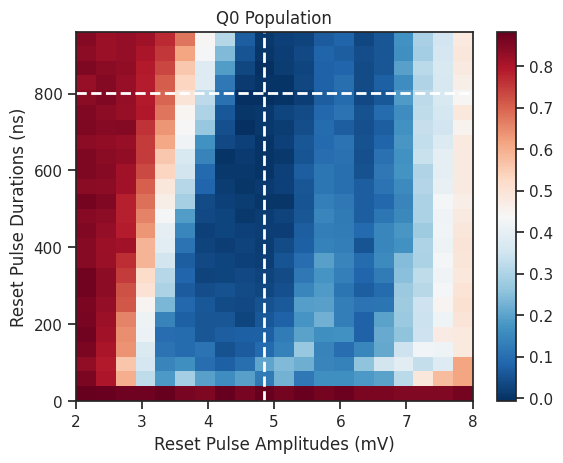

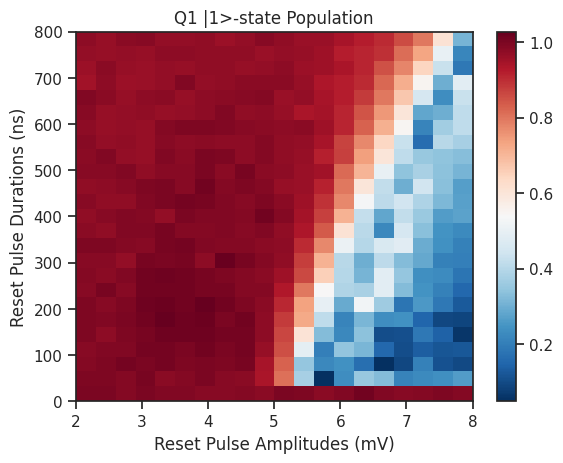

In [ ]:
cm = sns.color_palette("RdBu_r", as_cmap=True)
sns.set_style("ticks")
idx = [plot_index,min_id]
ax = plt.imshow(magnitudes0, aspect='auto',extent =[x.min(), x.max(),0, y.max()],  origin ='lower',cmap = cm)
plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]-1))
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q0 Population')
plt.colorbar()
plt.savefig('images/reset/202403/reset_chevron_q0_f.png',dpi=300)

plt.show()

plt.imshow(magnitudes1, aspect='auto',extent =[x.min(), x.max(),0, 800],  origin ='lower',cmap = cm)
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q1 |1>-state Population')
plt.colorbar()
plt.savefig('images/reset/202403/reset_chevron_q1_f.png',dpi=300)

plt.show()
# plt.imshow(total_magnitude, aspect='auto',extent =[x.max(), x.min(), y.min(), y.max()],  origin ='lower')
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
# plt.colorbar()
# plt.show()

## Reset CR - e

## Reset CR - e

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv


# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-17`5522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20240315'
path = f'data_directory/{date}'
names = np.sort(listdir(path))
# name = names[-1]
name = '20240315-103301-076-0004fa-reset_chevron-cr-e'
print(name)
dp = f'data_directory/{date}/{name}/dataset.hdf5'
ds = load_dataset(dp)
ds = ds.sortby('cz_pulse_amplitudesq17')
ds = ds.sortby('cz_pulse_amplitudesq22')

20240315-103301-076-0004fa-reset_chevron-cr-e


In [ ]:
dataset = ds
qubit = 'q17'
x = dataset[f'cz_pulse_amplitudes{qubit}'].values *100 # MHz
y = dataset[f'cz_pulse_durations{qubit}'].values*1e9 # ns

qubit = 'q17'
magnitudes0 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes0 = (magnitudes0-q17g)/(q17e-q17g)
qubit = 'q22'
magnitudes1 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes1 = (magnitudes1-q22g)/(q22e-q22g)
total_magnitude = (magnitudes0+magnitudes1)/2
# sum_list =[]
# for mag in total_magnitude.T:
#     sum_list.append(np.sum(mag))
min_index = np.argmin(magnitudes0)
min_index = np.unravel_index(min_index, magnitudes0.shape)
print(min_index)
print(x[min_index[1]],y[min_index[0]])
# min_index = [7,18]
# print(min_index)
# print(x[min_index[1]],y[min_index[0]])

(21, 4)
-16.842105263157897 841.0


cz_pulse_amplitudes_idx = 7
cz_pulse_amplitudes = -14.473684210526317
min = 0.014684690055252709
argmin = 10
min_t = 401.0


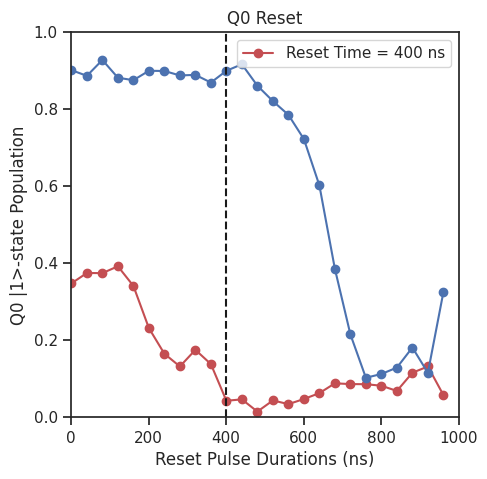

In [ ]:
%matplotlib inline

import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.set_style("ticks")

plt.figure(figsize=(5,5))
for i in [0]:
    plot_index = min_index[1]+i
    plot_index = 7
    print(f'cz_pulse_amplitudes_idx = {plot_index}')
    print(f'cz_pulse_amplitudes = {x[plot_index]}')
    print(f'min = {np.min(magnitudes0.T[plot_index])}')
    min_id = np.argmin(magnitudes0.T[plot_index])
    min_id = 10
    print(f'argmin = {min_id}')
    print(f'min_t = {y[min_id]}')
    plt.plot(y, magnitudes0.T[plot_index],'-r',marker="o",label = 'Reset Time = %1.0f ns'%(y[min_id]-1))
    plt.plot(y, magnitudes1.T[plot_index],'-b',marker="o")
    # plt.plot(y, total_magnitude.T[plot_index],'-k')
    plt.vlines(y[min_id],0,1,colors='k',linestyles='dashed')
    plt.xlabel('Reset Pulse Durations (ns)')
    plt.ylabel('Q0 |1>-state Population')
    plt.title('Q0 Reset')
    plt.ylim(0,1)
    plt.xlim(0,1000)
    plt.legend(loc='upper right', bbox_to_anchor=(1,1))
plt.savefig('images/reset/202403/reset_chevron_q0_e_cr_cut.png',dpi=300)
plt.show()

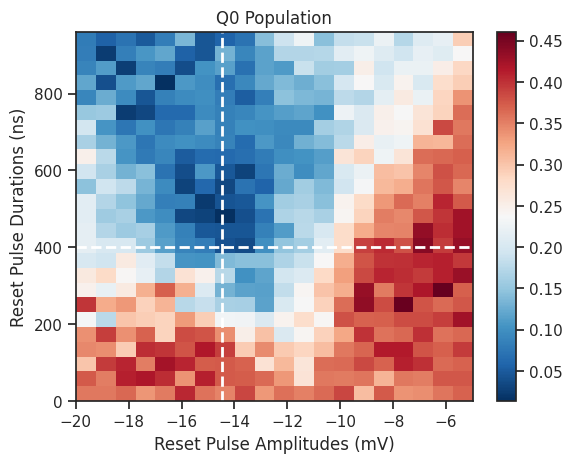

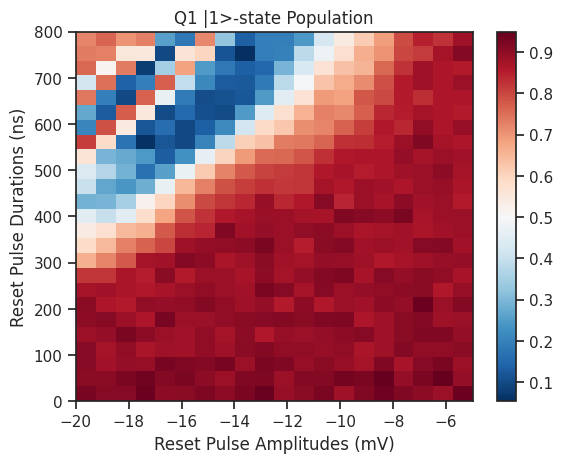

In [ ]:
cm = sns.color_palette("RdBu_r", as_cmap=True)
sns.set_style("ticks")
idx = [plot_index,min_id]
ax = plt.imshow(magnitudes0, aspect='auto',extent =[x.min(), x.max(),0, y.max()],  origin ='lower',cmap = cm)
plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]-1))
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q0 Population')
plt.colorbar()
plt.savefig('images/reset/202403/reset_chevron_q0_e_cr.png',dpi=300)

plt.show()

plt.imshow(magnitudes1, aspect='auto',extent =[x.min(), x.max(),0, 800],  origin ='lower',cmap = cm)
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q1 |1>-state Population')
plt.colorbar()
plt.savefig('images/reset/202403/reset_chevron_q1_e_cr.png',dpi=300)

plt.show()
# plt.imshow(total_magnitude, aspect='auto',extent =[x.max(), x.min(), y.min(), y.max()],  origin ='lower')
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
# plt.colorbar()
# plt.show()

## Reset CR - f

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv


# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-17`5522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20240315'
path = f'data_directory/{date}'
names = np.sort(listdir(path))
# name = names[-1]
name = '20240315-103908-547-132b4a-reset_chevron-cr-f'
print(name)
dp = f'data_directory/{date}/{name}/dataset.hdf5'
ds = load_dataset(dp)
ds = ds.sortby('cz_pulse_amplitudesq17')
ds = ds.sortby('cz_pulse_amplitudesq22')

20240315-103908-547-132b4a-reset_chevron-cr-f


In [ ]:
dataset = ds
qubit = 'q17'
x = dataset[f'cz_pulse_amplitudes{qubit}'].values *100 # MHz
y = dataset[f'cz_pulse_durations{qubit}'].values*1e9 # ns

qubit = 'q17'
magnitudes0 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes0 = (magnitudes0-q17g)/(q17e-q17g)
qubit = 'q22'
magnitudes1 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes1 = (magnitudes1-q22g)/(q22e-q22g)
total_magnitude = (magnitudes0+magnitudes1)/2
# sum_list =[]
# for mag in total_magnitude.T:
#     sum_list.append(np.sum(mag))
min_index = np.argmin(magnitudes0)
min_index = np.unravel_index(min_index, magnitudes0.shape)
print(min_index)
print(x[min_index[1]],y[min_index[0]])
# min_index = [7,18]
# print(min_index)
# print(x[min_index[1]],y[min_index[0]])

(12, 7)
-14.473684210526317 481.00000000000006


cz_pulse_amplitudes_idx = 7
cz_pulse_amplitudes = -14.473684210526317
min = 0.03160382687842936
argmin = 10
min_t = 401.0


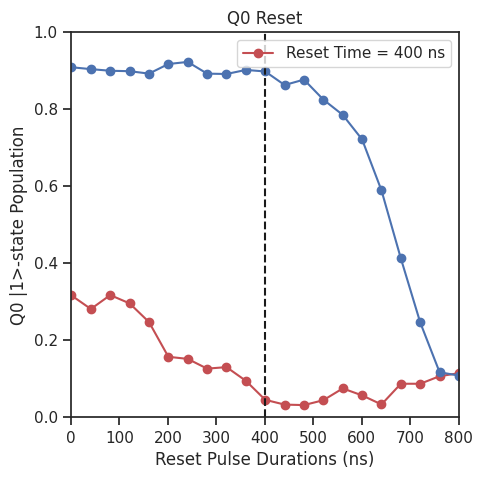

In [ ]:
%matplotlib inline

import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.set_style("ticks")

plt.figure(figsize=(5,5))
for i in [0]:
    plot_index = min_index[1]+i
    plot_index = 7
    print(f'cz_pulse_amplitudes_idx = {plot_index}')
    print(f'cz_pulse_amplitudes = {x[plot_index]}')
    print(f'min = {np.min(magnitudes0.T[plot_index])}')
    min_id = np.argmin(magnitudes0.T[plot_index])
    min_id = 10
    print(f'argmin = {min_id}')
    print(f'min_t = {y[min_id]}')
    plt.plot(y, magnitudes0.T[plot_index],'-r',marker="o",label = 'Reset Time = %1.0f ns'%(y[min_id]-1))
    plt.plot(y, magnitudes1.T[plot_index],'-b',marker="o")
    # plt.plot(y, total_magnitude.T[plot_index],'-k')
    plt.vlines(y[min_id],0,1,colors='k',linestyles='dashed')
    plt.xlabel('Reset Pulse Durations (ns)')
    plt.ylabel('Q0 |1>-state Population')
    plt.title('Q0 Reset')
    plt.ylim(0,1)
    plt.xlim(0,800)
    plt.legend(loc='upper right', bbox_to_anchor=(1,1))
plt.savefig('images/reset/202403/reset_chevron_q0_f_cr_cut.png',dpi=300)
plt.show()

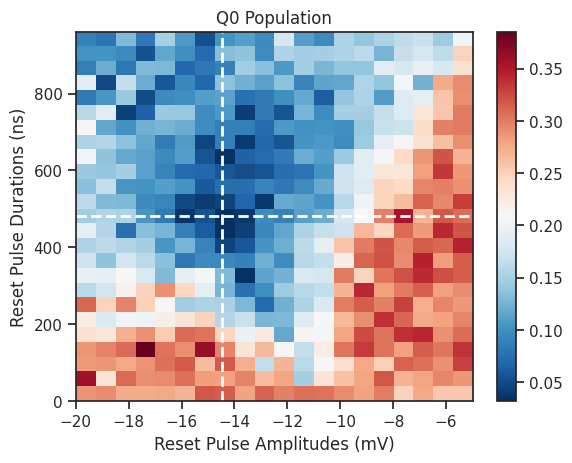

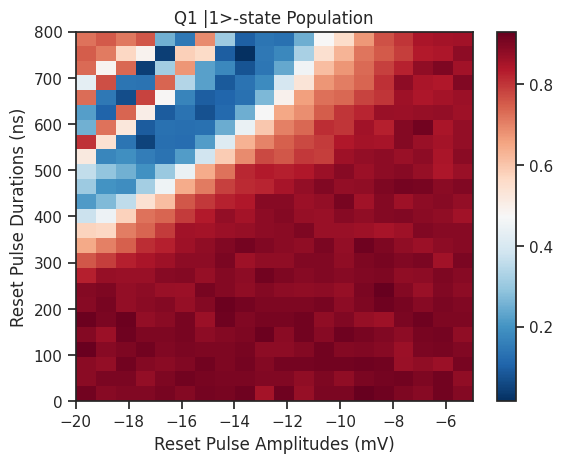

In [ ]:
cm = sns.color_palette("RdBu_r", as_cmap=True)
sns.set_style("ticks")
idx = [plot_index,min_id]
ax = plt.imshow(magnitudes0, aspect='auto',extent =[x.min(), x.max(),0, y.max()],  origin ='lower',cmap = cm)
plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]-1))
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q0 Population')
plt.colorbar()
plt.savefig('images/reset/202403/reset_chevron_q0_f_cr.png',dpi=300)

plt.show()

plt.imshow(magnitudes1, aspect='auto',extent =[x.min(), x.max(),0, 800],  origin ='lower',cmap = cm)
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q1 |1>-state Population')
plt.colorbar()
plt.savefig('images/reset/202403/reset_chevron_q1_f_cr.png',dpi=300)

plt.show()
# plt.imshow(total_magnitude, aspect='auto',extent =[x.max(), x.min(), y.min(), y.max()],  origin ='lower')
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
# plt.colorbar()
# plt.show()

In [ ]:
reset_data_rep = np.array([[0.    ,0.    ,0.    ,0.    ,0.    ,0.    ,0.    ,0.    ,0.   ],
[0.    ,0.   , 0.   , 0.006 ,0.    ,0.    ,0.028 ,0.046 ,0.02 ],
[0.    ,0.    ,0.    ,0.003 ,0.    ,0.  ,  0. ,   0.  ,  0.031],
[0.000e+00, 0.000e+00 ,0.000e+00 ,0.000e+00 ,0.000e+00 ,0.000e+00, 9.266e-04 ,1.460e-03 ,0.000e+00],
[0.    ,0.    ,0.   , 0. ,   0.  ,  0. ,   0.011 ,0. ,   0.   ],
[0. ,   0.   , 0.  ,  0.   , 0.  ,  0.  ,  0.    ,0.008, 0.   ],
[0. ,   0.  ,  0.   , 0.  ,  0.016, 0.   , 0.009, 0.  ,  0.02 ],
 [0.  ,  0.,    0.   , 0.001, 0.    ,0.033 ,0.027 ,0.    ,0.   ],
  [0.000e+00 ,9.692e-04 ,0.000e+00 ,0.000e+00 ,0.000e+00 ,2.502e-02, 5.597e-03 ,2.773e-03 ,2.308e-02]
])
reset_fidelity_rep = 1-np.mean(reset_data_rep,axis=0)
reset_std_rep = np.std(reset_data_rep,axis=0)
print(reset_fidelity_rep)
print(reset_std_rep)
print(np.mean(reset_fidelity_rep[3:6]),np.mean(reset_std_rep[3:6]))
print(np.mean(reset_fidelity_rep[6:9]),np.mean(reset_std_rep[6:9]))

[1.         0.99989231 1.         0.99888889 0.99822222 0.99355333
 0.99094182 0.99352967 0.98954667]
[0.         0.00030459 0.         0.00196889 0.00502831 0.0122064
 0.01058684 0.01419325 0.01206573]
0.9968881481481482 0.006401201400984063
0.9913393851851852 0.012281937618138618


In [ ]:
reset_data = np.array([[0.004, 0.002, 0.    ,0.008,0.013,0.01 ,0.136,0.105,0.048],
[0.    ,0.    ,0.    ,0.02  ,0.014 ,0.055 ,0.102 ,0.09  ,0.134],
[0.    ,0.    ,0.    ,0.    ,0.001 ,0.    ,0.128 ,0.118 ,0.14 ],
[0.   , 0.    ,0.    ,0.    ,0.    ,0.    ,0.051 ,0.041 ,0.087],
[0.    ,0.    ,0.    ,0.    ,0.    ,0.007 ,0.109 ,0.078 ,0.082],
 [0.009, 0.009 ,0.    ,0.    ,0.    ,0.    ,0.126 ,0.147 ,0.099],
 [0.    ,0.    ,0.006 ,0.022 ,0.052 ,0.047 ,0.197 ,0.175 ,0.137],
 [0.    ,0.016 ,0.    ,0.011 ,0.    ,0.019 ,0.127 ,0.101 ,0.085],
 [0.    ,0.   , 0.    ,0.    ,0.    ,0.    ,0.065 ,0.061 ,0.086],
  [0.000e+00 ,0.000e+00 ,0.000e+00 ,0.000e+00 ,2.158e-02 ,8.423e-04 ,1.211e-01 ,1.309e-01, 1.487e-01],
 [0.    ,0.    ,0.   , 0.    ,0.    ,0.   , 0.025, 0.075 ,0.059] ])
reset_fidelity = 1-np.mean(reset_data,axis=0)
reset_std = np.std(reset_data,axis=0)
print(reset_fidelity)
print(reset_std)
print(np.mean(reset_fidelity[3:6]),np.mean(reset_std[3:6]))
print(np.mean(reset_fidelity[6:9]),np.mean(reset_std[6:9]))
    

[0.99881818 0.99754545 0.99945455 0.99445455 0.99076545 0.98737797
 0.89208182 0.89800909 0.89948182]
[0.00272424 0.00499752 0.00172488 0.00815044 0.01536718 0.01905074
 0.04470666 0.03730246 0.03274382]


In [ ]:
print(np.mean(reset_fidelity[3:6]),np.mean(reset_std[3:6]))
print(np.mean(reset_fidelity[6:9]),np.mean(reset_std[6:9]))

0.9908659909090908 0.014189454246117833
0.8965242424242424 0.03825097945667922


In [ ]:
%matplotlib inline

import numpy as np
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv

def mitigate(v,cm_inv):
    u = np.dot(v,cm_inv)
    # print(u,np.sum(u))
    def m(t):
        return norm(u-np.array(t))
    def con(t):
        return t[0]+t[1]+t[2]-1
    cons = ({'type': 'eq', 'fun': con},
            {'type': 'ineq', 'fun': lambda t: t[0]},
            {'type': 'ineq', 'fun': lambda t: t[1]},
            {'type': 'ineq', 'fun': lambda t: t[2]})
    result = minimize(m, v, method='SLSQP', constraints=cons)
    w = np.abs(np.round(result.x,10))
    # print(w)
    return w

dataset = ds
for qubit in ['q13']:
# for qubit in ['q13','q14']:
# qubit = 'q13'
    data_var = f'y{qubit}'

    for coord in dataset.coords:
        if f'control_ons{qubit}' in str(coord):
            sweep_coord = coord
        elif f'ramsey_phases{qubit}' in str(coord):
            state_coord = coord
        elif 'shot' in str(coord):
            shot_coord = coord

    independents = dataset[state_coord].values[:-3]
    calibs = dataset[state_coord].values[-3:]
    sweeps = dataset.coords[sweep_coord]
    shots = len(dataset[shot_coord].values)
    magnitudes = []
    for indx, _ in enumerate(sweeps):
        # indx = 0
        # print(f'{indx = }')
        # print(f'{ro_amplitude.values = }')
        y = np.repeat(calibs,shots)
        IQ_complex = np.array([])
        for state, _ in enumerate(calibs):
            IQ_complex_0 = dataset[data_var].isel({sweep_coord:indx,state_coord:-3+state})
            IQ_complex = np.append(IQ_complex,IQ_complex_0)
        # IQ = np.array([I,Q]).T
        IQ = IQ_complex.reshape(-1,2)
        lda = LinearDiscriminantAnalysis(solver = "svd", store_covariance=True)
        # breakpoint()
        # print(IQ)
        cla = lda.fit(IQ,y)
        y_pred = cla.predict(IQ)

        cm = confusion_matrix(y,y_pred)
        cm_norm = confusion_matrix(y,y_pred,normalize='true')
        cm_inv = inv(cm_norm)
        assignment = np.trace(cm_norm)/len(calibs)
        print(f'{assignment = }')

        # disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
        # disp.plot()
        # plt.show()

        raw_data = dataset[data_var].isel({sweep_coord:indx}).values
        raw_shape = raw_data.shape
        data_y_pred = cla.predict(raw_data.reshape(-1,2))
        data_y_pred = np.transpose(data_y_pred.reshape(raw_shape[:-1]))
        # print(data_y_pred.shape)
        # print(data_y_pred)
        data_res_shape = list(data_y_pred.shape[:-1])
        data_res_shape.append(len(calibs))

        data_res = np.array([])
        for index_2, sweep_2 in enumerate(data_y_pred):
            uniques, counts = np.unique(sweep_2, return_counts=True)
            raw_prob = counts/len(sweep_2)
            # print(raw_prob)
            mitigate_prob = mitigate(raw_prob,cm_inv)
            data_res = np.append(data_res,mitigate_prob)
            # print(mitigate_prob)
        data_res = data_res.reshape(data_res_shape)
        magnitudes.append(data_res)
    magnitudes = np.array(magnitudes)
    marker = ['-','--']
    legend = ['off','on']
    x = range(4)
    # colors = plt.get_cmap('RdBu_r')(np.linspace(0.2, 0.8, len(x)))
    # colors = plt.get_cmap('RdYlGn')(np.linspace(0.2, 0.8, 2))
    colors = plt.get_cmap('tab20c')
    for index,magnitude in enumerate(magnitudes):
        plt.plot(independents,magnitude[:-3,0],f'{marker[index]}',c=colors(1),label=f'0_{legend[index]}')
        plt.plot(independents,magnitude[:-3,1],f'{marker[index]}',c=colors(1+4),label=f'1_{legend[index]}')
        plt.plot(independents,magnitude[:-3,2],f'{marker[index]}',c=colors(1+4*2),label=f'2_{legend[index]}')
        plt.ylim(-0.01,1.01)
        plt.legend(loc = 'upper right')
        # plt.xlim(np.min(independents),np.max(independents))
    plt.title(f'cz_calibration_ssro_{qubit}')
    plt.savefig(f'{path}/{name}/cz_calibration_ssro_{qubit}.png')
    plt.show()

NameError: name 'state_coord' is not defined

## Reset QC Square

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv


# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-17`5522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20240224'
path = f'data_directory/{date}'
names = np.sort(listdir(path))
name = names[-1]
name = '20240224-221808-278-3fbc22-reset_chevron'
print(name)
dp = f'data_directory/{date}/{name}/dataset.hdf5'
ds = load_dataset(dp)
ds = ds.sortby('cz_pulse_amplitudesq17')
ds = ds.sortby('cz_pulse_amplitudesq22')

20240224-221808-278-3fbc22-reset_chevron


In [ ]:
dataset = ds
qubit = 'q17'
x = dataset[f'cz_pulse_amplitudes{qubit}'].values *100 # MHz
y = dataset[f'cz_pulse_durations{qubit}'].values*1e9 # ns

qubit = 'q17'
magnitudes0 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
q17g,q17e = np.min(magnitudes0),np.max(magnitudes0)
magnitudes0 = (magnitudes0-q17g)/(q17e-q17g)
qubit = 'q22'
magnitudes1 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes1 = (magnitudes1-q22g)/(q22e-q22g)
total_magnitude = (magnitudes0+magnitudes1)/2
# sum_list =[]
# for mag in total_magnitude.T:
#     sum_list.append(np.sum(mag))
min_index = np.argmin(magnitudes0)
min_index = np.unravel_index(min_index, magnitudes0.shape)
print(min_index)
print(x[min_index[1]],y[min_index[0]])
# min_index = [7,18]
# print(min_index)
# print(x[min_index[1]],y[min_index[0]])

(16, 9)
4.736842105263158 17.0


In [ ]:
# %matplotlib inline
# plot_index = min_index[0]
# # plot_index = 2
# print(f'cz_pulse_durations = {y[plot_index]}')
# plt.figure(figsize=(5,5))
# plt.plot(x, magnitudes0[plot_index],'-r')
# plt.plot(x, magnitudes1[plot_index],'-b')
# # plt.plot(x, total_magnitude[plot_index],'-k')
# plt.vlines(x[min_index[1]],0,1,colors='k',linestyles='dashed')
# plt.ylim(np.min(magnitudes0),np.max(magnitudes1))
# plt.show()

cz_pulse_amplitudes_idx = 11
cz_pulse_amplitudes = 5.7894736842105265
min = 0.3730487496133666
argmin = 6
min_t = 7.000000000000001


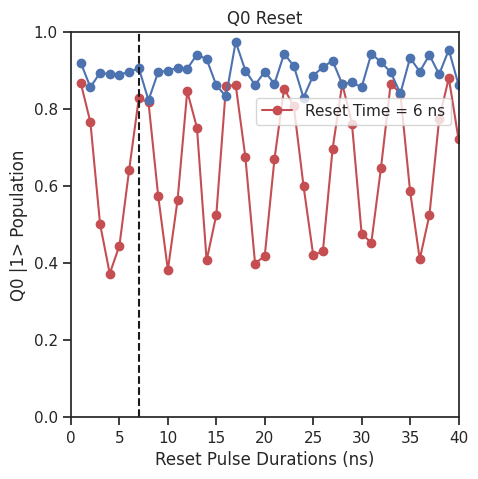

In [ ]:
%matplotlib inline

import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.set_style("ticks")

plt.figure(figsize=(5,5))
for i in [2]:
    plot_index = min_index[1]+i
    print(f'cz_pulse_amplitudes_idx = {plot_index}')
    # plot_index = 12
    print(f'cz_pulse_amplitudes = {x[plot_index]}')
    print(f'min = {np.min(magnitudes0.T[plot_index])}')
    min_id = np.argmin(magnitudes0.T[plot_index])
    min_id = 6
    print(f'argmin = {min_id}')
    print(f'min_t = {y[min_id]}')
    plt.plot(y, magnitudes0.T[plot_index],'-r',marker="o",label = 'Reset Time = %1.0f ns'%(y[min_id]-1))
    plt.plot(y, magnitudes1.T[plot_index],'-b',marker="o")
    # plt.plot(y, total_magnitude.T[plot_index],'-k')
    plt.vlines(y[min_id],0,1,colors='k',linestyles='dashed')
    plt.xlabel('Reset Pulse Durations (ns)')
    plt.ylabel('Q0 |1> Population')
    plt.title('Q0 Reset')
    plt.ylim(0,1)
    plt.xlim(0,40)
    plt.legend(loc='upper right', bbox_to_anchor=(1,0.85))
plt.savefig('reset/reset_chevron_q0_e_cut.png',dpi=300)
plt.show()

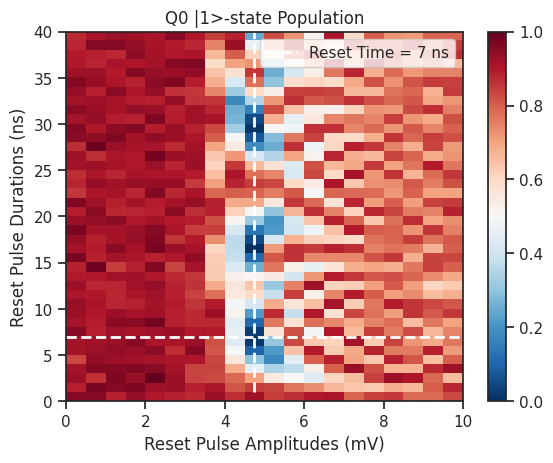

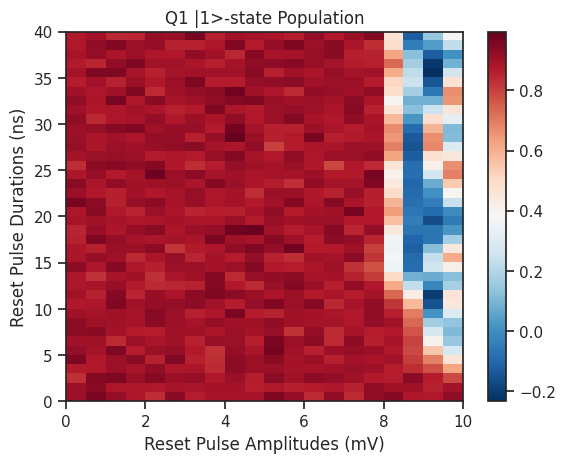

In [ ]:
cm = sns.color_palette("RdBu_r", as_cmap=True)
sns.set_style("ticks")
idx = [9,6]
ax = plt.imshow(magnitudes0, aspect='auto',extent =[x.min(), x.max(),0, 40],  origin ='lower',cmap = cm)
plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]))
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q0 |1>-state Population')
plt.colorbar()
plt.legend(loc='upper right', bbox_to_anchor=(1,1))
plt.savefig('reset/reset_chevron_q0_e_square.png',dpi=300)
plt.show()

plt.imshow(magnitudes1, aspect='auto',extent =[x.min(), x.max(),0, 40],  origin ='lower',cmap = cm)
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q1 |1>-state Population')
plt.colorbar()
plt.savefig('reset/reset_chevron_q1_e_square.png',dpi=300)
plt.show()
# plt.imshow(total_magnitude, aspect='auto',extent =[x.max(), x.min(), y.min(), y.max()],  origin ='lower')
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
# plt.colorbar()
# plt.show()

## Reset QC

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv


# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-17`5522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20240225'
path = f'data_directory/{date}'
names = np.sort(listdir(path))
name = names[-1]
name = '20240225-001628-108-1f557a-reset_chevron'
print(name)
dp = f'data_directory/{date}/{name}/dataset.hdf5'
ds = load_dataset(dp)
ds = ds.sortby('cz_pulse_amplitudesq17')
ds = ds.sortby('cz_pulse_amplitudesq22')

20240225-001628-108-1f557a-reset_chevron


In [ ]:
dataset = ds
qubit = 'q17'
x = dataset[f'cz_pulse_amplitudes{qubit}'].values *100 # MHz
y = dataset[f'cz_pulse_durations{qubit}'].values*1e9 # ns

qubit = 'q17'
magnitudes0 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
q17g,q17e = np.min(magnitudes0),np.max(magnitudes0)
magnitudes0 = (magnitudes0-q17g)/(q17e-q17g)
qubit = 'q22'
magnitudes1 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes1 = (magnitudes1-q22g)/(q22e-q22g)
total_magnitude = (magnitudes0+magnitudes1)/2
# sum_list =[]
# for mag in total_magnitude.T:
#     sum_list.append(np.sum(mag))
min_index = np.argmin(magnitudes0)
min_index = np.unravel_index(min_index, magnitudes0.shape)
print(min_index)
print(x[min_index[1]],y[min_index[0]])
# min_index = [7,18]
# print(min_index)
# print(x[min_index[1]],y[min_index[0]])

(39, 5)
5.052631578947368 79.0


In [ ]:
# %matplotlib inline
# plot_index = min_index[0]
# # plot_index = 2
# print(f'cz_pulse_durations = {y[plot_index]}')
# plt.figure(figsize=(5,5))
# plt.plot(x, magnitudes0[plot_index],'-r')
# plt.plot(x, magnitudes1[plot_index],'-b')
# # plt.plot(x, total_magnitude[plot_index],'-k')
# plt.vlines(x[min_index[1]],0,1,colors='k',linestyles='dashed')
# plt.ylim(np.min(magnitudes0),np.max(magnitudes1))
# plt.show()

cz_pulse_amplitudes_idx = 7
cz_pulse_amplitudes = 5.473684210526316
min = 0.43959779731672227
argmin = 6
min_t = 13.000000000000002


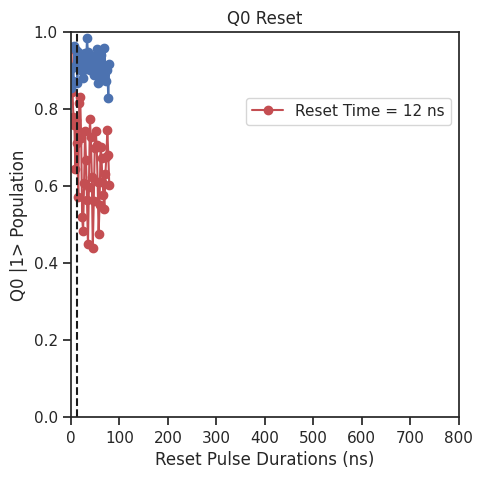

In [ ]:
%matplotlib inline

import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.set_style("ticks")

plt.figure(figsize=(5,5))
for i in [2]:
    plot_index = min_index[1]+i
    print(f'cz_pulse_amplitudes_idx = {plot_index}')
    # plot_index = 12
    print(f'cz_pulse_amplitudes = {x[plot_index]}')
    print(f'min = {np.min(magnitudes0.T[plot_index])}')
    min_id = np.argmin(magnitudes0.T[plot_index])
    min_id = 6
    print(f'argmin = {min_id}')
    print(f'min_t = {y[min_id]}')
    plt.plot(y, magnitudes0.T[plot_index],'-r',marker="o",label = 'Reset Time = %1.0f ns'%(y[min_id]-1))
    plt.plot(y, magnitudes1.T[plot_index],'-b',marker="o")
    # plt.plot(y, total_magnitude.T[plot_index],'-k')
    plt.vlines(y[min_id],0,1,colors='k',linestyles='dashed')
    plt.xlabel('Reset Pulse Durations (ns)')
    plt.ylabel('Q0 |1> Population')
    plt.title('Q0 Reset')
    plt.ylim(0,1)
    plt.xlim(0,800)
    plt.legend(loc='upper right', bbox_to_anchor=(1,0.85))
plt.savefig('reset/reset_chevron_q0_e_cut.png',dpi=300)
plt.show()

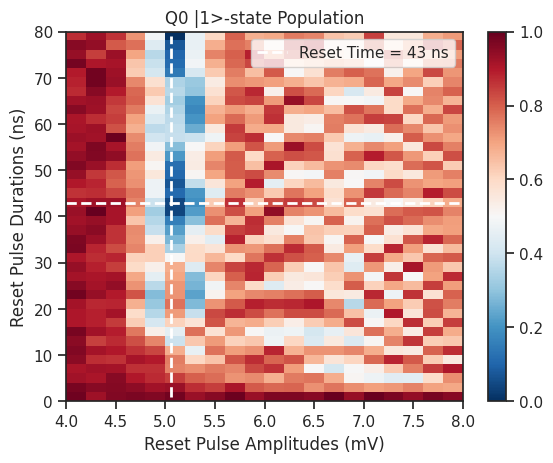

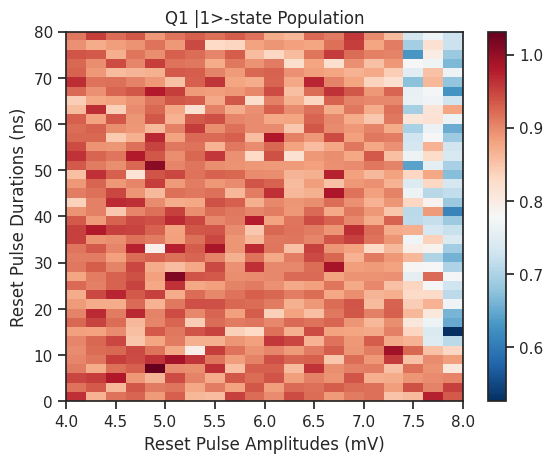

In [ ]:
cm = sns.color_palette("RdBu_r", as_cmap=True)
sns.set_style("ticks")
idx = [5,21]
ax = plt.imshow(magnitudes0, aspect='auto',extent =[x.min(), x.max(),0, 80],  origin ='lower',cmap = cm)
plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]))
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q0 |1>-state Population')
plt.colorbar()
plt.legend(loc='upper right', bbox_to_anchor=(1,1))
plt.savefig('reset/reset_chevron_q0_f_square.png',dpi=300)
plt.show()

plt.imshow(magnitudes1, aspect='auto',extent =[x.min(), x.max(),0, 80],  origin ='lower',cmap = cm)
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q1 |1>-state Population')
plt.colorbar()
plt.savefig('reset/reset_chevron_q1_f_square.png',dpi=300)
plt.show()
# plt.imshow(total_magnitude, aspect='auto',extent =[x.max(), x.min(), y.min(), y.max()],  origin ='lower')
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
# plt.colorbar()
# plt.show()

## Reset QC Ramp

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv


# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-17`5522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20240221'
path = f'data_directory/{date}'
names = np.sort(listdir(path))
name = names[-1]
name = '20240221-171648-363-9ae378-reset_chevron'
print(name)
dp = f'data_directory/{date}/{name}/dataset.hdf5'
ds = load_dataset(dp)
ds = ds.sortby('cz_pulse_amplitudesq17')
ds = ds.sortby('cz_pulse_amplitudesq22')

20240221-171648-363-9ae378-reset_chevron


In [ ]:
dataset = ds
qubit = 'q17'
x = dataset[f'cz_pulse_amplitudes{qubit}'].values *100 # MHz
y = dataset[f'cz_pulse_durations{qubit}'].values*1e9 # ns

qubit = 'q17'
magnitudes0 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
q17g,q17e = np.min(magnitudes0),np.max(magnitudes0)
magnitudes0 = (magnitudes0-q17g)/(q17e-q17g)
qubit = 'q22'
magnitudes1 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes1 = (magnitudes1-q22g)/(q22e-q22g)
total_magnitude = (magnitudes0+magnitudes1)/2
# sum_list =[]
# for mag in total_magnitude.T:
#     sum_list.append(np.sum(mag))
min_index = np.argmin(magnitudes0)
min_index = np.unravel_index(min_index, magnitudes0.shape)
print(min_index)
print(x[min_index[1]],y[min_index[0]])
# min_index = [7,18]
# print(min_index)
# print(x[min_index[1]],y[min_index[0]])

(28, 15)
7.894736842105263 113.0


In [ ]:
# %matplotlib inline
# plot_index = min_index[0]
# # plot_index = 2
# print(f'cz_pulse_durations = {y[plot_index]}')
# plt.figure(figsize=(5,5))
# plt.plot(x, magnitudes0[plot_index],'-r')
# plt.plot(x, magnitudes1[plot_index],'-b')
# # plt.plot(x, total_magnitude[plot_index],'-k')
# plt.vlines(x[min_index[1]],0,1,colors='k',linestyles='dashed')
# plt.ylim(np.min(magnitudes0),np.max(magnitudes1))
# plt.show()

cz_pulse_amplitudes_idx = 15
cz_pulse_amplitudes = 7.894736842105263
min = 0.0
argmin = 6
min_t = 25.000000000000004


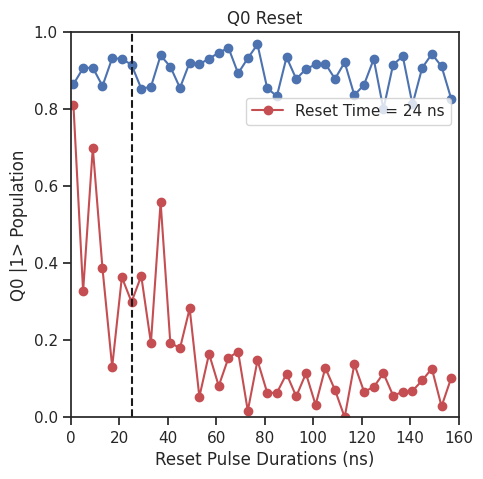

In [ ]:
%matplotlib inline

import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.set_style("ticks")

plt.figure(figsize=(5,5))
for i in [0]:
    plot_index = min_index[1]+i
    print(f'cz_pulse_amplitudes_idx = {plot_index}')
    # plot_index = 12
    print(f'cz_pulse_amplitudes = {x[plot_index]}')
    print(f'min = {np.min(magnitudes0.T[plot_index])}')
    min_id = np.argmin(magnitudes0.T[plot_index])
    min_id = 6
    print(f'argmin = {min_id}')
    print(f'min_t = {y[min_id]}')
    plt.plot(y, magnitudes0.T[plot_index],'-r',marker="o",label = 'Reset Time = %1.0f ns'%(y[min_id]-1))
    plt.plot(y, magnitudes1.T[plot_index],'-b',marker="o")
    # plt.plot(y, total_magnitude.T[plot_index],'-k')
    plt.vlines(y[min_id],0,1,colors='k',linestyles='dashed')
    plt.xlabel('Reset Pulse Durations (ns)')
    plt.ylabel('Q0 |1> Population')
    plt.title('Q0 Reset')
    plt.ylim(0,1)
    plt.xlim(0,160)
    plt.legend(loc='upper right', bbox_to_anchor=(1,0.85))
plt.savefig('reset/reset_chevron_q0_e_cut.png',dpi=300)
plt.show()

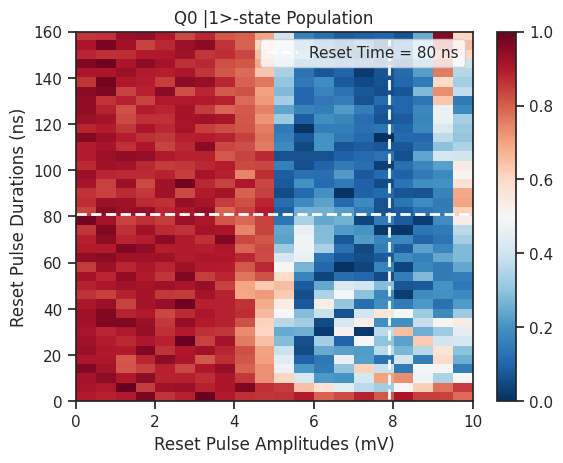

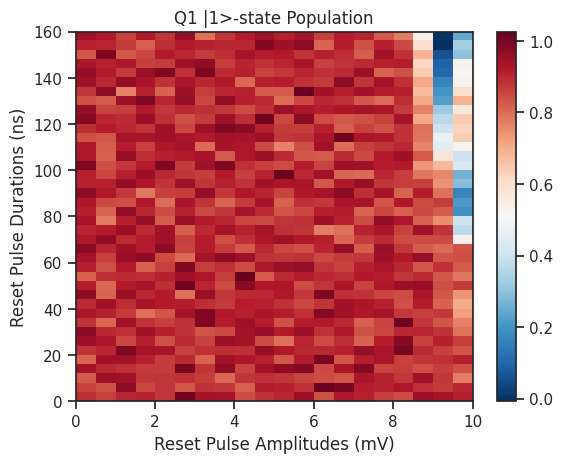

In [ ]:
cm = sns.color_palette("RdBu_r", as_cmap=True)
sns.set_style("ticks")
idx = [15,20]
ax = plt.imshow(magnitudes0, aspect='auto',extent =[x.min(), x.max(),0, 160],  origin ='lower',cmap = cm)
plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]-1))
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q0 |1>-state Population')
plt.colorbar()
plt.legend(loc='upper right', bbox_to_anchor=(1,1))
plt.savefig('reset/reset_chevron_q0_e_ramp.png',dpi=300)
plt.show()

plt.imshow(magnitudes1, aspect='auto',extent =[x.min(), x.max(),0, 160],  origin ='lower',cmap = cm)
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q1 |1>-state Population')
plt.colorbar()
plt.savefig('reset/reset_chevron_q1_e_ramp.png',dpi=300)
plt.show()
# plt.imshow(total_magnitude, aspect='auto',extent =[x.max(), x.min(), y.min(), y.max()],  origin ='lower')
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
# plt.colorbar()
# plt.show()

## Reset QC Ramp

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv


# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-17`5522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20240223'
path = f'data_directory/{date}'
names = np.sort(listdir(path))
name = names[-1]
name = '20240223-154544-562-ffc319-reset_chevron'
print(name)
dp = f'data_directory/{date}/{name}/dataset.hdf5'
ds = load_dataset(dp)
ds = ds.sortby('cz_pulse_amplitudesq17')
ds = ds.sortby('cz_pulse_amplitudesq22')

20240223-154544-562-ffc319-reset_chevron


In [ ]:
dataset = ds
qubit = 'q17'
x = dataset[f'cz_pulse_amplitudes{qubit}'].values *100 # MHz
y = dataset[f'cz_pulse_durations{qubit}'].values*1e9 # ns

qubit = 'q17'
magnitudes0 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
q17g,q17e = np.min(magnitudes0),np.max(magnitudes0)
magnitudes0 = (magnitudes0-q17g)/(q17e-q17g)
qubit = 'q22'
magnitudes1 = np.array([[np.linalg.norm(u) for u in v] for v in dataset[f'y{qubit}']])
magnitudes1 = (magnitudes1-q22g)/(q22e-q22g)
total_magnitude = (magnitudes0+magnitudes1)/2
# sum_list =[]
# for mag in total_magnitude.T:
#     sum_list.append(np.sum(mag))
min_index = np.argmin(magnitudes0)
min_index = np.unravel_index(min_index, magnitudes0.shape)
print(min_index)
print(x[min_index[1]],y[min_index[0]])
# min_index = [7,18]
# print(min_index)
# print(x[min_index[1]],y[min_index[0]])

(2, 13)
8.105263157894738 41.0


In [ ]:
# %matplotlib inline
# plot_index = min_index[0]
# # plot_index = 2
# print(f'cz_pulse_durations = {y[plot_index]}')
# plt.figure(figsize=(5,5))
# plt.plot(x, magnitudes0[plot_index],'-r')
# plt.plot(x, magnitudes1[plot_index],'-b')
# # plt.plot(x, total_magnitude[plot_index],'-k')
# plt.vlines(x[min_index[1]],0,1,colors='k',linestyles='dashed')
# plt.ylim(np.min(magnitudes0),np.max(magnitudes1))
# plt.show()

cz_pulse_amplitudes_idx = 13
cz_pulse_amplitudes = 8.105263157894738
min = 0.0
argmin = 6
min_t = 121.00000000000001


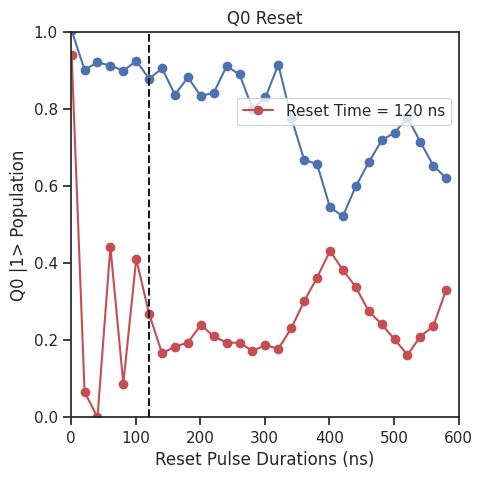

In [ ]:
%matplotlib inline

import seaborn as sns

# Apply the default theme
sns.set_theme()
sns.set_style("ticks")

plt.figure(figsize=(5,5))
for i in [0]:
    plot_index = min_index[1]+i
    print(f'cz_pulse_amplitudes_idx = {plot_index}')
    # plot_index = 12
    print(f'cz_pulse_amplitudes = {x[plot_index]}')
    print(f'min = {np.min(magnitudes0.T[plot_index])}')
    min_id = np.argmin(magnitudes0.T[plot_index])
    min_id = 6
    print(f'argmin = {min_id}')
    print(f'min_t = {y[min_id]}')
    plt.plot(y, magnitudes0.T[plot_index],'-r',marker="o",label = 'Reset Time = %1.0f ns'%(y[min_id]-1))
    plt.plot(y, magnitudes1.T[plot_index],'-b',marker="o")
    # plt.plot(y, total_magnitude.T[plot_index],'-k')
    plt.vlines(y[min_id],0,1,colors='k',linestyles='dashed')
    plt.xlabel('Reset Pulse Durations (ns)')
    plt.ylabel('Q0 |1> Population')
    plt.title('Q0 Reset')
    plt.ylim(0,1)
    plt.xlim(0,600)
    plt.legend(loc='upper right', bbox_to_anchor=(1,0.85))
plt.savefig('reset/reset_chevron_q0_e_cut.png',dpi=300)
plt.show()

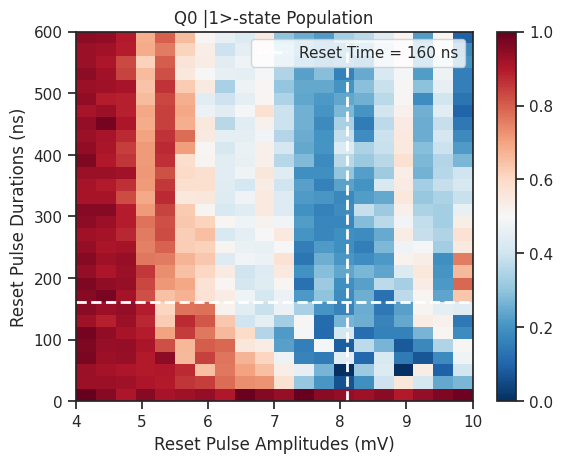

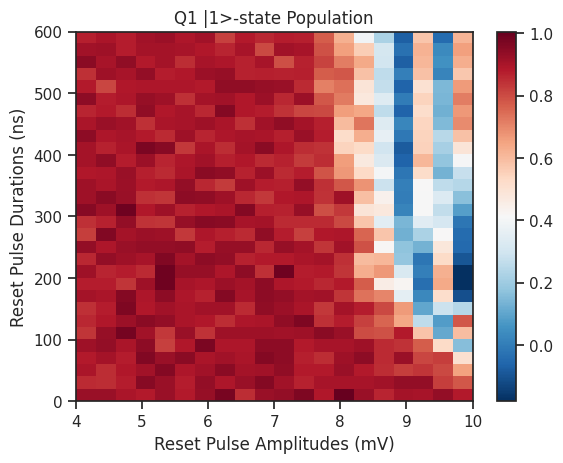

In [ ]:
cm = sns.color_palette("RdBu_r", as_cmap=True)
sns.set_style("ticks")
idx = [13,8]
ax = plt.imshow(magnitudes0, aspect='auto',extent =[x.min(), x.max(),0, 600],  origin ='lower',cmap = cm)
plt.vlines(x[idx[0]], y.min(), y.max(), linestyles='dashed' ,lw=2,colors='w')
plt.hlines(y[idx[1]], x.min(), x.max(), linestyles='dashed' ,lw=2,colors='w',label = 'Reset Time = %1.0f ns'%(y[idx[1]]-1))
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q0 |1>-state Population')
plt.colorbar()
plt.legend(loc='upper right', bbox_to_anchor=(1,1))
plt.savefig('reset/reset_chevron_q0_f_ramp.png',dpi=300)
plt.show()

plt.imshow(magnitudes1, aspect='auto',extent =[x.min(), x.max(),0, 600],  origin ='lower',cmap = cm)
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
plt.xlabel('Reset Pulse Amplitudes (mV)')
plt.ylabel('Reset Pulse Durations (ns)')
plt.title('Q1 |1>-state Population')
plt.colorbar()
plt.savefig('reset/reset_chevron_q1_f_ramp.png',dpi=300)
plt.show()
# plt.imshow(total_magnitude, aspect='auto',extent =[x.max(), x.min(), y.min(), y.max()],  origin ='lower')
# plt.vlines(x[min_index[1]], y.min(), y.max(), linestyles='dashed' ,colors='r')
# plt.hlines(y[min_index[0]], x.min(), x.max(), linestyles='dashed' ,colors='r')
# plt.colorbar()
# plt.show()

## CZ_calibration Data Broswing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-17`5522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20231231'
path = f'data_directory/{date}'
names = np.sort(listdir(path))
name = names[-1]
name = '20231231-121410-941-404eaf-cz_calibration_ssro'
print(name)
dp = f'data_directory/{date}/{name}/dataset.hdf5'
ds = load_dataset(dp)

20231231-121410-941-404eaf-cz_calibration_ssro


assignment = 0.6695963541666666
assignment = 0.6549479166666666


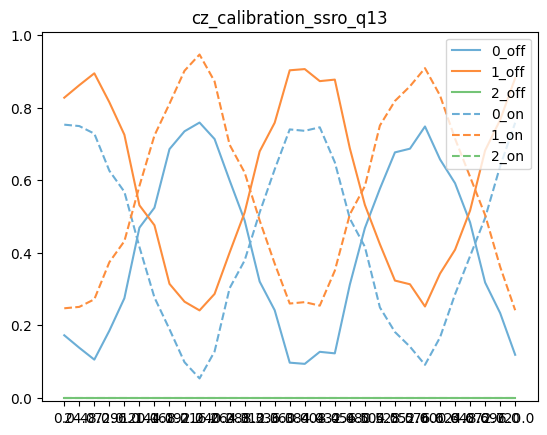

In [ ]:
%matplotlib inline

import numpy as np
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv

def mitigate(v,cm_inv):
    u = np.dot(v,cm_inv)
    # print(u,np.sum(u))
    def m(t):
        return norm(u-np.array(t))
    def con(t):
        return t[0]+t[1]+t[2]-1
    cons = ({'type': 'eq', 'fun': con},
            {'type': 'ineq', 'fun': lambda t: t[0]},
            {'type': 'ineq', 'fun': lambda t: t[1]},
            {'type': 'ineq', 'fun': lambda t: t[2]})
    result = minimize(m, v, method='SLSQP', constraints=cons)
    w = np.abs(np.round(result.x,10))
    # print(w)
    return w

dataset = ds
for qubit in ['q13']:
# for qubit in ['q13','q14']:
# qubit = 'q13'
    data_var = f'y{qubit}'

    for coord in dataset.coords:
        if f'control_ons{qubit}' in str(coord):
            sweep_coord = coord
        elif f'ramsey_phases{qubit}' in str(coord):
            state_coord = coord
        elif 'shot' in str(coord):
            shot_coord = coord

    independents = dataset[state_coord].values[:-3]
    calibs = dataset[state_coord].values[-3:]
    sweeps = dataset.coords[sweep_coord]
    shots = len(dataset[shot_coord].values)
    magnitudes = []
    for indx, _ in enumerate(sweeps):
        # indx = 0
        # print(f'{indx = }')
        # print(f'{ro_amplitude.values = }')
        y = np.repeat(calibs,shots)
        IQ_complex = np.array([])
        for state, _ in enumerate(calibs):
            IQ_complex_0 = dataset[data_var].isel({sweep_coord:indx,state_coord:-3+state})
            IQ_complex = np.append(IQ_complex,IQ_complex_0)
        # IQ = np.array([I,Q]).T
        IQ = IQ_complex.reshape(-1,2)
        lda = LinearDiscriminantAnalysis(solver = "svd", store_covariance=True)
        # breakpoint()
        # print(IQ)
        cla = lda.fit(IQ,y)
        y_pred = cla.predict(IQ)

        cm = confusion_matrix(y,y_pred)
        cm_norm = confusion_matrix(y,y_pred,normalize='true')
        cm_inv = inv(cm_norm)
        assignment = np.trace(cm_norm)/len(calibs)
        print(f'{assignment = }')

        # disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
        # disp.plot()
        # plt.show()

        raw_data = dataset[data_var].isel({sweep_coord:indx}).values
        raw_shape = raw_data.shape
        data_y_pred = cla.predict(raw_data.reshape(-1,2))
        data_y_pred = np.transpose(data_y_pred.reshape(raw_shape[:-1]))
        # print(data_y_pred.shape)
        # print(data_y_pred)
        data_res_shape = list(data_y_pred.shape[:-1])
        data_res_shape.append(len(calibs))

        data_res = np.array([])
        for index_2, sweep_2 in enumerate(data_y_pred):
            uniques, counts = np.unique(sweep_2, return_counts=True)
            raw_prob = counts/len(sweep_2)
            # print(raw_prob)
            mitigate_prob = mitigate(raw_prob,cm_inv)
            data_res = np.append(data_res,mitigate_prob)
            # print(mitigate_prob)
        data_res = data_res.reshape(data_res_shape)
        magnitudes.append(data_res)
    magnitudes = np.array(magnitudes)
    marker = ['-','--']
    legend = ['off','on']
    x = range(4)
    # colors = plt.get_cmap('RdBu_r')(np.linspace(0.2, 0.8, len(x)))
    # colors = plt.get_cmap('RdYlGn')(np.linspace(0.2, 0.8, 2))
    colors = plt.get_cmap('tab20c')
    for index,magnitude in enumerate(magnitudes):
        plt.plot(independents,magnitude[:-3,0],f'{marker[index]}',c=colors(1),label=f'0_{legend[index]}')
        plt.plot(independents,magnitude[:-3,1],f'{marker[index]}',c=colors(1+4),label=f'1_{legend[index]}')
        plt.plot(independents,magnitude[:-3,2],f'{marker[index]}',c=colors(1+4*2),label=f'2_{legend[index]}')
        plt.ylim(-0.01,1.01)
        plt.legend(loc = 'upper right')
        # plt.xlim(np.min(independents),np.max(independents))
    plt.title(f'cz_calibration_ssro_{qubit}')
    plt.savefig(f'{path}/{name}/cz_calibration_ssro_{qubit}.png')
    plt.show()

In [ ]:
np.diff(np.mean(magnitudes[:,:-3,2],axis = 1))

array([0.])

In [ ]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0.2, 0.8, 2))
print(colors[1])

[0.4        0.74117647 0.38823529 1.        ]


In [ ]:
print(colors)

In [ ]:
magnitudes[:,:-3,0]

array([[0.95328687, 1.        , 0.97489076, 0.98119963, 0.95625897,
        0.97826324, 0.97291053, 0.99195332, 0.96982418, 1.        ,
        0.95966036, 0.95933393, 0.95112348, 0.99720885, 0.9554089 ,
        0.98439055, 0.93278169, 0.99826859, 1.        , 0.98239483,
        0.96128176, 0.93895345, 0.96381981, 0.98376218, 0.91227093,
        0.95988543, 0.95262008, 0.96938914, 0.97041375, 0.9554089 ,
        0.9835155 ],
       [0.57196983, 0.62658829, 0.55304507, 0.57090802, 0.56681152,
        0.57872153, 0.57781171, 0.55342449, 0.55171574, 0.56521868,
        0.57140295, 0.55482668, 0.53874458, 0.57462524, 0.63326385,
        0.51777045, 0.58888649, 0.56366518, 0.59009961, 0.56085663,
        0.57303289, 0.56764709, 0.57985954, 0.55793859, 0.61847084,
        0.53434505, 0.56776091, 0.55990903, 0.54272767, 0.61843364,
        0.58206046]])

In [ ]:
# %matplotlib inline
# qubit = 'q13'
# ds0 = ds[f'y{qubit}']
# ds0 = (ds0.values).reshape(1024*34*2,2)
# # print(ds0)
# plt.plot(ds0[:,0],ds0[:,1],'.r')
# plt.show()

# qubit = 'q14'
# ds0 = ds[f'y{qubit}']
# ds0 = (ds0.values).reshape(1024*34*2,2)
# # print(ds0)
# plt.plot(ds0[:,0],ds0[:,1],'.b')
# plt.show()

In [ ]:
# %matplotlib inline
# qubit = 'q13'

# ds0 = ds[f'y{qubit}'].sel(ramsey_phasesq13='c0',control_onsq13=False )
# ds1 = ds[f'y{qubit}'].sel(ramsey_phasesq13='c1',control_onsq13=False )
# ds2 = ds[f'y{qubit}'].sel(ramsey_phasesq13='c2',control_onsq13=False )

# plt.plot(ds0[:,0].values,ds0[:,1].values,'.r')
# plt.plot(ds1[:,0].values,ds1[:,1].values,'.b')
# plt.plot(ds2[:,0].values,ds2[:,1].values,'.g')
# plt.show()

# %matplotlib inline
# qubit = 'q14'

# ds0 = ds[f'y{qubit}'].sel(ramsey_phasesq14='c0',control_onsq14=False )
# ds1 = ds[f'y{qubit}'].sel(ramsey_phasesq14='c1',control_onsq14=False )
# ds2 = ds[f'y{qubit}'].sel(ramsey_phasesq14='c2',control_onsq14=False )

# plt.plot(ds0[:,0].values,ds0[:,1].values,'.r')
# plt.plot(ds1[:,0].values,ds1[:,1].values,'.b')
# plt.plot(ds2[:,0].values,ds2[:,1].values,'.g')
# plt.show()

In [ ]:
# nested join using join()
my_string = ",".join(str(element) for element in list(cm_inv.flatten()))
print(my_string)

In [ ]:
my_list = my_string.split(",")
size = int(len(my_list)**0.5)
my_list = np.array([float(i) for i in my_list]).reshape(size,size)

print(my_list)

[[ 1.36277471 -0.15911288 -0.20366183]
 [-0.29625934  1.42344841 -0.12718907]
 [-0.14756231 -0.02953404  1.17709634]]


## ro_amplitude_optimization_gef Data Broswing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
name = '20231225-165135-093-09e0cd-cz_calibration_ssro'
dp = f'data_directory/{name[:8]}/{name}/dataset.hdf5'

In [ ]:
ds = load_dataset(dp)
ds

<xarray.Dataset>
Dimensions:           (shot: 1024, ramsey_phasesq14: 34, control_onsq14: 2,
                       ReIm: 2, ramsey_phasesq13: 34, control_onsq13: 2)
Coordinates:
  * shot              (shot) int32 0 1 2 3 4 5 ... 1018 1019 1020 1021 1022 1023
  * ramsey_phasesq14  (ramsey_phasesq14) object '0.0' '24.0' '48.0' ... 'e' 'f'
  * ramsey_phasesq13  (ramsey_phasesq13) object '0.0' '24.0' '48.0' ... 'e' 'f'
  * control_onsq14    (control_onsq14) bool False True
  * control_onsq13    (control_onsq13) bool False True
Dimensions without coordinates: ReIm
Data variables:
    yq14              (shot, ramsey_phasesq14, control_onsq14, ReIm) float64 ...
    yq13              (shot, ramsey_phasesq13, control_onsq13, ReIm) float64 ...
Attributes:
    name:     cz_calibration_ssro
    tuid:     20231225-165135-093

0.091


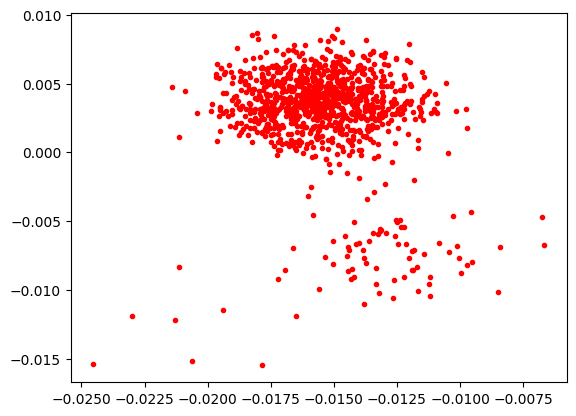

In [ ]:
%matplotlib inline
# select the data with ro_amplitudesq12 = 0.051
amp = ds.ro_amplitudesq12.values[5]
# for amp in ds.ro_amplitudesq12.values:
print(amp)
qubit = 'q130'
ds0 = ds[f'y{qubit}'].sel(ro_amplitudesq13=amp ,state = 0 )
ds1 = ds[f'y{qubit}'].sel(ro_amplitudesq13=amp ,state = 1 )
ds2 = ds[f'y{qubit}'].sel(ro_amplitudesq13=amp ,state = 2 )
# ds0 = (ds0.values).reshape(4096*3,2)
# ds1 = (ds1.values).reshape(4096*3,2)
# ds2 = (ds2.values).reshape(4096*3,2)

cut0 = 0
cut1 = 15
plt.plot(ds0[:,0].values,ds0[:,1].values,'.r')
# plt.plot(ds1[:,0].values,ds1[:,1].values,'.b')
# plt.plot(ds1[cut0::cut1,0].values,ds1[cut0::cut1,1].values,'*')
# plt.plot(ds2[:,0].values,ds2[:,1].values,'.g')
plt.show()

assignment = 0.8388671875


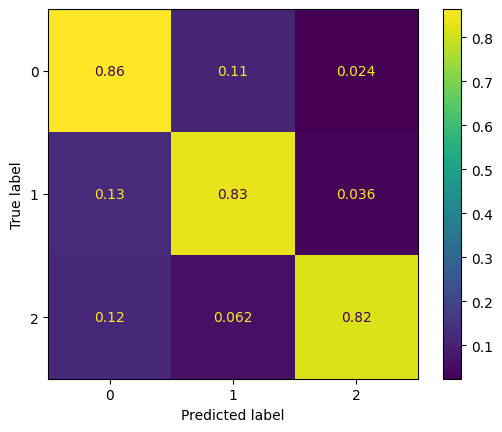

In [ ]:
import numpy as np
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

dataset = ds
qubit = 'q12'
data_var = f'y{qubit}0'

for coord in dataset.coords:
    if f'amplitudes{qubit}' in str(coord):
        amplitude_coord = coord
    elif 'state' in str(coord):
        state_coord = coord
    elif 'shot' in str(coord):
        shot_coord = coord

independents = dataset[state_coord].values
amplitudes = dataset.coords[amplitude_coord]
shots = len(dataset[shot_coord].values)
fit_results = {}
# for indx, ro_amplitude in enumerate(amplitudes):
indx = 3
# print(f'{indx = }')
# print(f'{ro_amplitude.values = }')
y = np.repeat(independents,shots)
IQ_complex = np.array([])
for state in independents:
    IQ_complex_0 = dataset[data_var].isel({amplitude_coord:[indx],state_coord:state})
    IQ_complex = np.append(IQ_complex,IQ_complex_0)
# I = IQ_complex.real.flatten()
# Q = IQ_complex.imag.flatten()
# IQ = np.array([I,Q]).T
IQ = IQ_complex.reshape(-1,2)
lda = LinearDiscriminantAnalysis(solver = "svd", store_covariance=True)
# breakpoint()
# print(IQ)
y_pred = lda.fit(IQ,y).predict(IQ)

cm = confusion_matrix(y,y_pred)
cm_norm = confusion_matrix(y,y_pred,normalize='true')
# assignment = 1 - 1/2 * (err_wr_0 + err_wr_1)
assignment = np.trace(cm_norm)/len(independents)
print(f'{assignment = }')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot()
plt.show()

In [ ]:
from numpy.linalg import inv
print(cm_norm)
cm_inv = inv(cm_norm)
print(cm_inv)
print(np.dot(cm_inv,cm_norm))

[[0.86425781 0.11132812 0.02441406]
 [0.12890625 0.83496094 0.03613281]
 [0.12011719 0.0625     0.81738281]]
[[ 1.18425448 -0.1557683  -0.02848618]
 [-0.17588313  1.22477137 -0.04888825]
 [-0.16058158 -0.0707597   1.23134128]]
[[ 1.00000000e+00 -4.40186082e-17 -8.83285957e-18]
 [ 3.78725371e-17  1.00000000e+00  8.53131584e-18]
 [ 2.47198095e-17  0.00000000e+00  1.00000000e+00]]


In [ ]:
v = [0.87,0.11,1-0.87-0.11]
print(v)

[0.87, 0.11, 0.020000000000000004]


In [ ]:
def mitigated(v,a0,a1):
    return np.dot(cm_inv,v)-[a0,a1,1-a0-a1]
res = minimize(mitigated, v)


TypeError: mitigated() missing 2 required positional arguments: 'a0' and 'a1'

In [ ]:
a,b = 0.8,0.1
v = [a,b,1-a-b]
u = np.dot(cm_inv,v)
print(v,u,np.sum(u))

[0.8, 0.05, 0.14999999999999997] [ 0.93534224 -0.08680117  0.05269794] 0.9012390169552309


In [ ]:
# Define the function to be minimized
from scipy.linalg import norm
def m(t):
    return norm(u-np.array(t))

In [ ]:
# Define the constraints
def con(t):
   return t[0]+t[1]+t[2]-1
# Define the constraints in the form required by the minimize function
cons = ({'type': 'eq', 'fun': con},
        {'type': 'ineq', 'fun': lambda t: t[0]},
        {'type': 'ineq', 'fun': lambda t: t[1]},
        {'type': 'ineq', 'fun': lambda t: t[2]})

In [ ]:
from scipy.optimize import minimize
result = minimize(m, v, method='SLSQP', constraints=cons)
print(np.abs(np.round(result.x,10)))

[0.94132282 0.         0.05867718]


In [ ]:
cm_inv

array([[ 1.18425448, -0.1557683 , -0.02848618],
       [-0.17588313,  1.22477137, -0.04888825],
       [-0.16058158, -0.0707597 ,  1.23134128]])

In [ ]:
# nested join using join()
my_string = ",".join(str(element) for element in list(cm_inv.flatten()))
print(my_string)

1.1842544812150915,-0.15576829843331808,-0.028486182781773627,-0.1758831264569345,1.2247713733537886,-0.04888824689685401,-0.1605815783706242,-0.07075969795381643,1.2313412763244407


In [ ]:
my_list = my_string.split(",")
size = int(len(my_list)**0.5)
my_list = np.array([float(i) for i in my_list]).reshape(size,size)

print(my_list)

[[ 1.18425448 -0.1557683  -0.02848618]
 [-0.17588313  1.22477137 -0.04888825]
 [-0.16058158 -0.0707597   1.23134128]]


## Redis Parameters

In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
node = 'cz_chevron'
qubits = ['q21','q22','q21_q22']
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"cs:{qubit}")
    # Print the redis config line by line
    print(redis_config['cz_chevron'])
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")

Qubit parameters q21:
not_calibrated
Qubit parameters q22:
not_calibrated
Qubit parameters q21_q22:
not_calibrated


In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
# qubits = ['q13','q14']
qubits = ['q21_q22','q16_q21']
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"couplers:{qubit}")
    # Print the redis config line by line
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")
    print(redis_config['cz_pulse_frequency'])
    print(redis_config['cz_pulse_duration'])
    print(redis_config['cz_pulse_amplitude'])
    # print(redis_config['cz_phase'])
    # print(redis_config['cz_pop_loss'])
    # print(redis_config['cz_leakage'])

Qubit parameters q21_q22:
215627272.72727272
3.313354605772508e-07
0.15
Qubit parameters q16_q21:
344000000.0
3.7186273915678165e-07
0.1


In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q21','q22']
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    # for key, value in redis_config.items():
        # print(f"{key}: {value}")
    print(redis_config['cz_pulse_frequency'])
    print(redis_config['cz_pulse_duration'])
    print(redis_config['cz_pulse_amplitude'])
    # print(redis_config['cz_phase'])
    # print(redis_config['cz_pop_loss'])
    # print(redis_config['cz_leakage'])

Qubit parameters q21:
nan
nan
nan
Qubit parameters q22:
nan
nan
nan


In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q12','q13','q14','q15']
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    print(redis_config['freq_01'])
    print(redis_config['freq_12'])
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")

Qubit parameters q12:
3366985350.8172603
3173745577.505435
Qubit parameters q13:
3583392807.127604
3344617330.110173
Qubit parameters q14:
3333262125.7570114
3133075732.4790416
Qubit parameters q15:
3872762251.21086
3631663526.956842


## Save VNA values

In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
# qubits = [ 'q12','q13','q14','q15']
qubits = ['q16','q17','q18','q19','q20','q21','q22','q23','q24','q25']
qubit_freq_01_list,qubit_freq_ro_list,qubit_freq_12_list = {},{},{}
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")
    print(redis_config['ro_freq'])
    print(redis_config['freq_01'])
    print(redis_config['freq_12'])
    qubit_freq_ro_list[qubit] = redis_config['ro_freq']
    qubit_freq_01_list[qubit] = redis_config['freq_01']
    qubit_freq_12_list[qubit] = redis_config['freq_12']

Qubit parameters q16:
6489739796.816151
3189000000.0
2993400000.0
Qubit parameters q17:
7059399869.2122345
3932200000.0
3699800000.0
Qubit parameters q18:
6712742151.173621
3254000000.0
3057400000.0
Qubit parameters q19:
6818362148.027776
3914600000.0
3681600000.0
Qubit parameters q20:
6494839241.529742
3333200000.0
3132200000.0
Qubit parameters q21:
6752736342.162048
3772200000.0
3543000000.0
Qubit parameters q22:
6476748475.479722
3325800000.0
3130400000.0
Qubit parameters q23:
7051822087.369359
3910400000.0
3674200000.0
Qubit parameters q24:
6583576730.713829
3271000000.0
3072400000.0
Qubit parameters q25:
6852972354.877701
4008800000.0
3769200000.0


In [ ]:
for qubit in qubits:
    d = float(qubit_freq_ro_list[qubit]) - (float(qubit_freq_01_list[qubit])+float(qubit_freq_12_list[qubit]))
    print(d/1e6)

307.3397968161507
-572.6001307877655
401.3421511736212
-777.8378519722243
29.43924152974224
-562.4636578379517
20.548475479722022
-532.777912630641
240.17673071382904
-925.0276451222992


In [ ]:
from config_files.VNA_values import VNA_resonator_frequencies, VNA_qubit_frequencies, VNA_f12_frequencies
for qubit in qubits:
    VNA_resonator_frequencies[qubit] = float(qubit_freq_ro_list[qubit])
    VNA_qubit_frequencies[qubit] = float(qubit_freq_01_list[qubit])
    VNA_f12_frequencies[qubit] = float(qubit_freq_12_list[qubit])
# rewrite the VNA_values.py file
with open('config_files/VNA_values.py', 'w') as f:
    f.write(f"VNA_resonator_frequencies = {VNA_resonator_frequencies}\n")
    f.write(f"VNA_qubit_frequencies = {VNA_qubit_frequencies}\n")
    f.write(f"VNA_f12_frequencies = {VNA_f12_frequencies}\n")

In [ ]:
import numpy as np
print(VNA_resonator_frequencies)
print(VNA_qubit_frequencies)
print(VNA_f12_frequencies)
anahar = (np.array(list(VNA_f12_frequencies.values()))-np.array(list(VNA_qubit_frequencies.values()))) / 1e6
print(anahar)

{'q16': 6489739796.816151, 'q17': 7059399869.2122345, 'q18': 6712742151.173621, 'q19': 6818362148.027776, 'q20': 6494839241.529742, 'q21': 6752736342.162048, 'q22': 6476748475.479722, 'q23': 7051822087.369359, 'q24': 6583576730.713829, 'q25': 6852972354.877701, 'q11': 6934503303.198933}
{'q16': 3189000000.0, 'q17': 3932200000.0, 'q18': 3254000000.0, 'q19': 3914600000.0, 'q20': 3333200000.0, 'q21': 3772200000.0, 'q22': 3325800000.0, 'q23': 3910400000.0, 'q24': 3271000000.0, 'q25': 4008800000.0}
{'q16': 2993400000.0, 'q17': 3699800000.0, 'q18': 3057400000.0, 'q19': 3681600000.0, 'q20': 3132200000.0, 'q21': 3543000000.0, 'q22': 3130400000.0, 'q23': 3674200000.0, 'q24': 3072400000.0, 'q25': 3769200000.0}
[-195.6 -232.4 -196.6 -233.  -201.  -229.2 -195.4 -236.2 -198.6 -239.6]


In [ ]:
# VNA_resonator_frequencies = {'q11': 6934572785.610347, 'q12': 6606753684.764918, 'q13': 6688313321.558435, 'q14': 6331351280.923618, 'q15': 6933698139.447023, 'q16': 6491000000.0, 'q17': 7059000000.0, 'q18': 6712000000.0, 'q19': 6818000000.0, 'q20': 6494000000.0, 'q21': 6751000000.0, 'q22': 6477000000.0, 'q23': 7052000000.0, 'q24': 6583000000.0, 'q25': 6853000000.0}
# VNA_qubit_frequencies = {'q11': 3714895945.38633, 'q12': 3366961177.836733, 'q13': 3585016857.038436, 'q14': 3334060710.6204877, 'q15': 3872936707.280074, 'q16': 3189000000.0, 'q17': 3932000000.0, 'q18': 3254000000.0, 'q19': 3921000000.0, 'q20': 3333000000.0, 'q21': 3773000000.0, 'q22': 3326000000.0, 'q23': 3911000000.0, 'q24': 3271000000.0, 'q25': 4009000000.0}
# VNA_f12_frequencies = {'q11': 3480306890.6912713, 'q12': 3174059567.052809, 'q13': 3343386697.937837, 'q14': 3133224381.376709, 'q15': 3631763299.7146664, 'q16': 2993000000.0, 'q17': 3699000000.0, 'q18': 3154000000.0, 'q19': 3682000000.0, 'q20': 3233000000.0, 'q21': 3542000000.0, 'q22': 3131000000.0, 'q23': 3674000000.0, 'q24': 3171000000.0, 'q25': 3770000000.0}
